# DSCI552: HW4
### Alain Tamazian
### ID#: 2073746513

Important Note: <br>
Keep in mind that it will take several hours for this program to run. <br>
Also, while I am not sure if it is due to my computer sometimes not being able to handle the heavier computations, the kernel has died on occasion during the loading process. For some sections (which I noted), I had to sample down the dataset's size (or SMOTE with a smaller ratio) to decrease the likelihood of the kernel dying. While now the kernel dying happens rarely, bare in mind that it is still possible and you may need to rerun/reload the program. At the time of the submission, the HW ran properly (to completition) -- albeit very slowly.

In [1]:
# Cell for all imports necessary for HW4

import statistics
import math
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from tqdm import tqdm

from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import weka.core.jvm as jvm
import javabridge
from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls
import weka.core.converters as converters
from javabridge import JWrapper, JClassWrapper
from javabridge.jutil import JavaException
from weka.core import types as arrays

jvm.start(packages=True)
import weka.core.packages as packages
packages.install_package("SMOTE")
from weka.filters import Filter
from weka.classifiers import FilteredClassifier


DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [2]:
SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-P", "1080"])
jvm.stop()


If you get: <br>
Failed to instantiate weka.filters.supervised.instance.SMOTE: Can't find a permissible class called: weka.filters.supervised.instance.SMOTE
>Depending on how you have your environment and Weka (especially SMOTE) downlaoded and set up, you will probably need to restart/reload the kernel so that the "SMOTE" package gets integrated. Then you should be able to run everything. <br>

There may be other alternative errors and solutions, but that would be based on your own environment installations and setup and not the code itself. I can just say that the code runs properly given that all the required programs and packages are properly downloaded and intergrated

---------------
## 1.a

Download the Communities and Crime data1 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [3]:
# I changed the "community_names" file to a text, and the "community" file to a csv as suggested in the footnote
# The "community.csv" file does not include attribute names; will need to add that from the "community_names" text file

communities_data = "../data/communities.csv"
communities_attr = "../data/communities_names.text"

fileIn = open(communities_attr)

attrL = []
for line in fileIn:
    if "@attribute" in line:
        attr = line.split()[1]
        attrL.append(attr)
# print(len(attrL))

fileIn.close()

communities_df = pd.read_csv(communities_data, header=None, names=attrL, na_values="?")

raw_train_df = communities_df.iloc[:1495]
raw_test_df = communities_df.iloc[1495:]

# display(communities_df)
display(raw_train_df)
display(raw_test_df)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)
# uncomment the line below if you want all rows/columns of data displayed instead of just a sample of 10
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)


state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1490      6     NaN        NaN     Hillsboroughtown     8        0.00   
1491      6     NaN        NaN           Orangecity     8        0.16   
1492     13     NaN        NaN         Waycrosscity     8        0.01   
1493     39    85.0    49056.0           Mentorcity     8        0.06   
1494     34    17.0    79610.0      WestNewYorktown     8        0.05   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ...      0.12   
1              0.16          0.12          0.74          0.45  ...      0.02   
2              0.42          0.49          0.56          0.17  ...      0.01   
3              0.77          1.00          0.08          0.12  ...      0.02   
4              0.55          0.02          0.95          0.09  ...      0.04   
...             ...           ...           ...           ...  ...       ...   
1490           0.59          0.01          0.69          1.00  ...      0.02   
1491           0.62          0.03          0.74          0.48  ...      0.07   
1492           0.36          0.95          0.24          0.03  ...      0.03   
1493           0.53          0.01          0.98          0.05  ...      0.08   
1494           0.43          0.08          0.65          0.12  ...      0.00   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0        0.26            0.20       0.06           0.04                 0.90   
1        0.12            0.45        NaN            NaN                  NaN   
2        0.21            0.02        NaN            NaN                  NaN   
3        0.39            0.28        NaN            NaN                  NaN   
4        0.09            0.02        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1490     0.14            0.22        NaN            NaN                  NaN   
1491     0.40            0.14       0.07           0.05                 0.85   
1492     0.12            0.01        NaN            NaN                  NaN   
1493     0.15            0.02        NaN            NaN                  NaN   
1494     1.00            1.00       0.00           0.01                 0.77   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                     0.5                 0.32             0.14   
1                     NaN                 0.00              NaN   
2                     NaN                 0.00              NaN   
3                     NaN                 0.00              NaN   
4                     NaN                 0.00              NaN   
...                   ...                  ...              ...   
1490                  NaN                 0.00              NaN   
1491                  0.5                 0.61             0.19   
1492                  NaN                 0.00              NaN   
1493                  NaN                 0.00              NaN   
1494                  0.0                 0.51             0.18   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1490                 0.03  
1491                 0.20  
1492                 0.30  
1493                 0.03  
1494                 0.23  

[1495 rows x 128 columns]

state  county  community      communityname  fold  population  \
1495      6     NaN        NaN     MillValleycity     8        0.00   
1496     48     NaN        NaN        LiveOakcity     8        0.00   
1497     35     NaN        NaN       Portalescity     8        0.00   
1498     42    17.0    25112.0      Fallstownship     8        0.04   
1499     51   683.0    48952.0       Manassascity     8        0.03   
...     ...     ...        ...                ...   ...         ...   
1989     12     NaN        NaN  TempleTerracecity    10        0.01   
1990      6     NaN        NaN        Seasidecity    10        0.05   
1991      9     9.0    80070.0      Waterburytown    10        0.16   
1992     25    17.0    72600.0        Walthamcity    10        0.08   
1993      6     NaN        NaN        Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
1495           0.20          0.03          0.91          0.23  ...      0.01   
1496           0.55          0.13          0.78          0.15  ...      0.01   
1497           0.52          0.04          0.59          0.05  ...      0.01   
1498           0.51          0.07          0.92          0.09  ...      0.06   
1499           0.59          0.20          0.75          0.19  ...      0.03   
...             ...           ...           ...           ...  ...       ...   
1989           0.40          0.10          0.87          0.12  ...      0.01   
1990           0.96          0.46          0.28          0.83  ...      0.02   
1991           0.37          0.25          0.69          0.04  ...      0.08   
1992           0.51          0.06          0.87          0.22  ...      0.03   
1993           0.78          0.14          0.46          0.24  ...      0.11   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
1495     0.23            0.73        NaN            NaN                  NaN   
1496     0.18            0.02        NaN            NaN                  NaN   
1497     0.18            0.00        NaN            NaN                  NaN   
1498     0.13            0.16        NaN            NaN                  NaN   
1499     0.23            0.06        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1989     0.28            0.05        NaN            NaN                  NaN   
1990     0.37            0.20        NaN            NaN                  NaN   
1991     0.32            0.18       0.08           0.06                 0.78   
1992     0.38            0.33       0.02           0.02                 0.79   
1993     0.30            0.05       0.08           0.04                 0.73   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
1495                  NaN                 0.00              NaN   
1496                  NaN                 0.00              NaN   
1497                  NaN                 0.00              NaN   
1498                  NaN                 0.00              NaN   
1499                  NaN                 0.00              NaN   
...                   ...                  ...              ...   
1989                  NaN                 0.00              NaN   
1990                  NaN                 0.00              NaN   
1991                  0.0                 0.91             0.28   
1992                  0.0                 0.22             0.18   
1993                  0.5                 1.00             0.13   

      ViolentCrimesPerPop  
1495                 0.12  
1496                 0.11  
1497                 0.12  
1498                 0.06  
1499                 0.12  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[499 rows x 128 columns]

---------------
## 1.b

The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [4]:
# (b) mentions that there are nonpredictive attributes we should ignore
# it makes more sense to remove them here, before splitting into train/test sets
# The "communities_names" text says that the first 5 features are nonpredictive

communities_df = communities_df.iloc[:, 5:]
attrL = attrL[5:]

raw_train_df = communities_df.iloc[:1495]
raw_test_df = communities_df.iloc[1495:]
# redundant train/test declaration; if time, remove either from here or 1.a 


I noticed that for some of the features, the missing values make up a vast majority. In this case, it seems kind of pointless to impute the mean value for all the missing rows, since our feature will be practically homogenous. I thought it would make more sense to just drop those columns entirely, since such attributes wouldn't hold much computational worth. On the contrary, it would even mislead our model.

However, I was told that for the sake of the exercise we should still impute here.

In [5]:
# The TA said: fit the data on the training data. To deal with the missing data on your test data, use the imputer fitted on your training data. 

# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer
# from sklearn.impute import SimpleImputer

# a standard impuation method is using the mean of the column values
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")

# Fit to train data, then transform/impute it
imputed_train_data = imputer.fit_transform(raw_train_df)

train_df = pd.DataFrame(imputed_train_data, columns=attrL)
display(train_df)

# Now we impute the test set based on the imputer trained on the training set
imputed_test_data = imputer.transform(raw_test_df)

test_df = pd.DataFrame(imputed_test_data, columns=attrL)
display(test_df)


population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1490        0.00           0.59          0.01          0.69          1.00   
1491        0.16           0.62          0.03          0.74          0.48   
1492        0.01           0.36          0.95          0.24          0.03   
1493        0.06           0.53          0.01          0.98          0.05   
1494        0.05           0.43          0.08          0.65          0.12   

      ...  LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0     ...             0.900000             0.500000                 0.32   
1     ...             0.713054             0.451883                 0.00   
2     ...             0.713054             0.451883                 0.00   
3     ...             0.713054             0.451883                 0.00   
4     ...             0.713054             0.451883                 0.00   
...   ...                  ...                  ...                  ...   
1490  ...             0.713054             0.451883                 0.00   
1491  ...             0.850000             0.500000                 0.61   
1492  ...             0.713054             0.451883                 0.00   
1493  ...             0.713054             0.451883                 0.00   
1494  ...             0.770000             0.000000                 0.51   

      PolicBudgPerPop  ViolentCrimesPerPop  
0            0.140000                 0.20  
1            0.190753                 0.67  
2            0.190753                 0.43  
3            0.190753                 0.12  
4            0.190753                 0.03  
...               ...                  ...  
1490         0.190753                 0.03  
1491         0.190000                 0.20  
1492         0.190753                 0.30  
1493         0.190753                 0.03  
1494         0.180000                 0.23  

[1495 rows x 123 columns]

population  householdsize  racepctblack  racePctWhite  racePctAsian  ...  \
0          0.00           0.20          0.03          0.91          0.23  ...   
1          0.00           0.55          0.13          0.78          0.15  ...   
2          0.00           0.52          0.04          0.59          0.05  ...   
3          0.04           0.51          0.07          0.92          0.09  ...   
4          0.03           0.59          0.20          0.75          0.19  ...   
..          ...            ...           ...           ...           ...  ...   
494        0.01           0.40          0.10          0.87          0.12  ...   
495        0.05           0.96          0.46          0.28          0.83  ...   
496        0.16           0.37          0.25          0.69          0.04  ...   
497        0.08           0.51          0.06          0.87          0.22  ...   
498        0.20           0.78          0.14          0.46          0.24  ...   

     LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0               0.713054             0.451883                 0.00   
1               0.713054             0.451883                 0.00   
2               0.713054             0.451883                 0.00   
3               0.713054             0.451883                 0.00   
4               0.713054             0.451883                 0.00   
..                   ...                  ...                  ...   
494             0.713054             0.451883                 0.00   
495             0.713054             0.451883                 0.00   
496             0.780000             0.000000                 0.91   
497             0.790000             0.000000                 0.22   
498             0.730000             0.500000                 1.00   

     PolicBudgPerPop  ViolentCrimesPerPop  
0           0.190753                 0.12  
1           0.190753                 0.11  
2           0.190753                 0.12  
3           0.190753                 0.06  
4           0.190753                 0.12  
..               ...                  ...  
494         0.190753                 0.09  
495         0.190753                 0.45  
496         0.280000                 0.23  
497         0.180000                 0.19  
498         0.130000                 0.48  

[499 rows x 123 columns]

---------------
## 1.c

Plot a correlation matrix for the features in the data set.

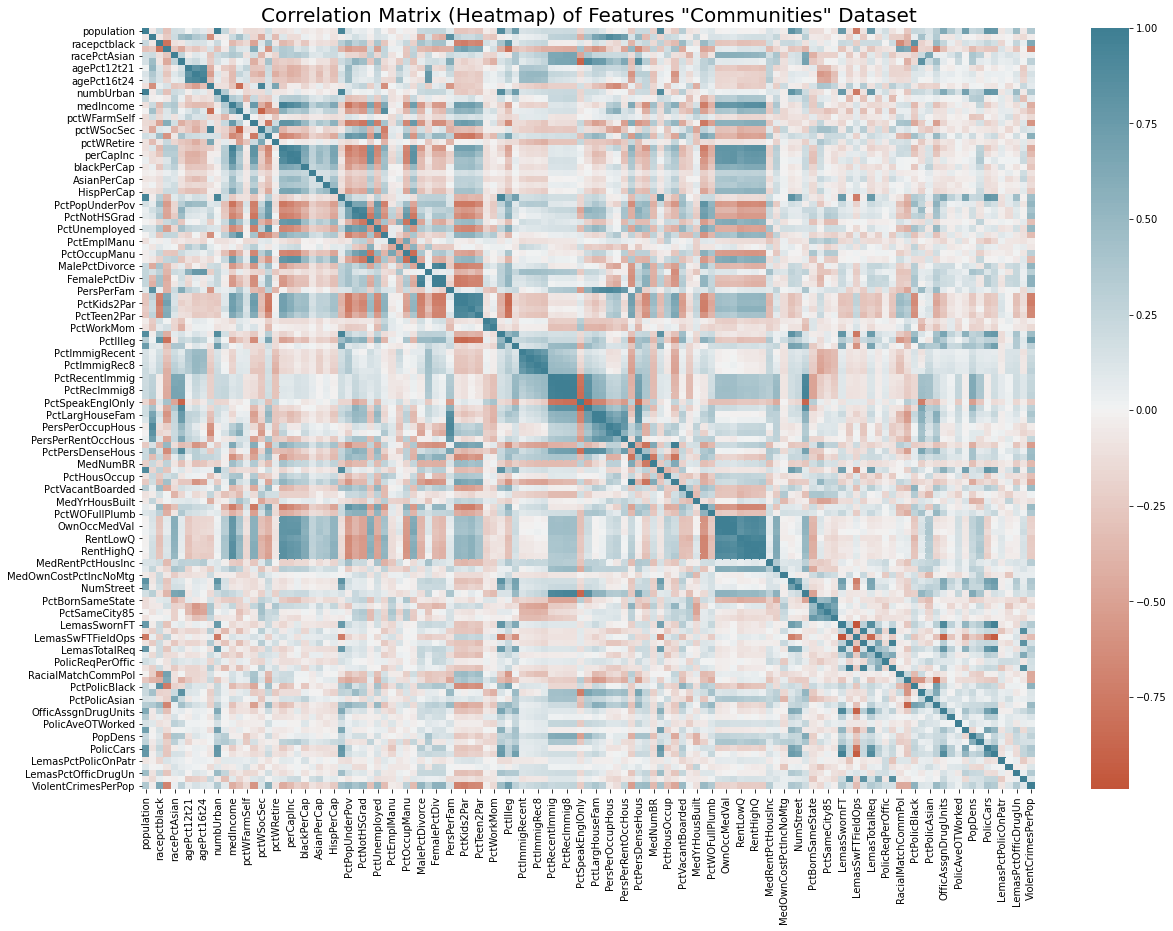

In [6]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
    
# correlation matrix with scatterplot pairplot matrix won't load for 128x128 features

# can uncommment the line below, to see all attribute names -- for reference
# print(attrL)

fig, ax = plt.subplots(figsize=(20, 14))
corr = communities_df.corr()
heatmap = sns.heatmap(corr,cmap=sns.diverging_palette(20, 220, n=200), ax=ax)
# Only every other feature name (label) is written on the axes -- due to not enough space
# It shouldn't matter though, since every is visualized nonetheless
plt.title("Correlation Matrix (Heatmap) of Features \"Communities\" Dataset", fontsize=20)

plt.show()


---------------
## 1.d

Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in
which s is sample standard deviation and m is sample mean.

In [7]:
cvL = []

for attr in attrL:
    cv = float(communities_df[attr].std()) / float(communities_df[attr].mean())
    cvL.append((attr, cv))

cv_df = pd.DataFrame(cvL, columns=(("Features", "CV")))
# print(cvL)
display(cv_df)

Features        CV
0             population  2.203503
1          householdsize  0.353298
2           racepctblack  1.410920
3           racePctWhite  0.323782
4           racePctAsian  1.359162
..                   ...       ...
118  LemasPctPolicOnPatr  0.306251
119  LemasGangUnitDeploy  0.921372
120  LemasPctOfficDrugUn  2.555266
121      PolicBudgPerPop  0.844368
122  ViolentCrimesPerPop  0.979015

[123 rows x 2 columns]

---------------
## 1.e

Pick ⌊√128⌋ features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [8]:
# The floor of √128 is just rounding down

# We use the "key" parameter to sort by the second tuple element
# lambda creates a mini-function
cvL.sort(reverse=True, key=lambda x:x[1])

highest_cvL = cvL[:int(math.sqrt(128))]
# print(highest_cvL)

highestCV_attrL = [attr for attr, cv in highest_cvL]


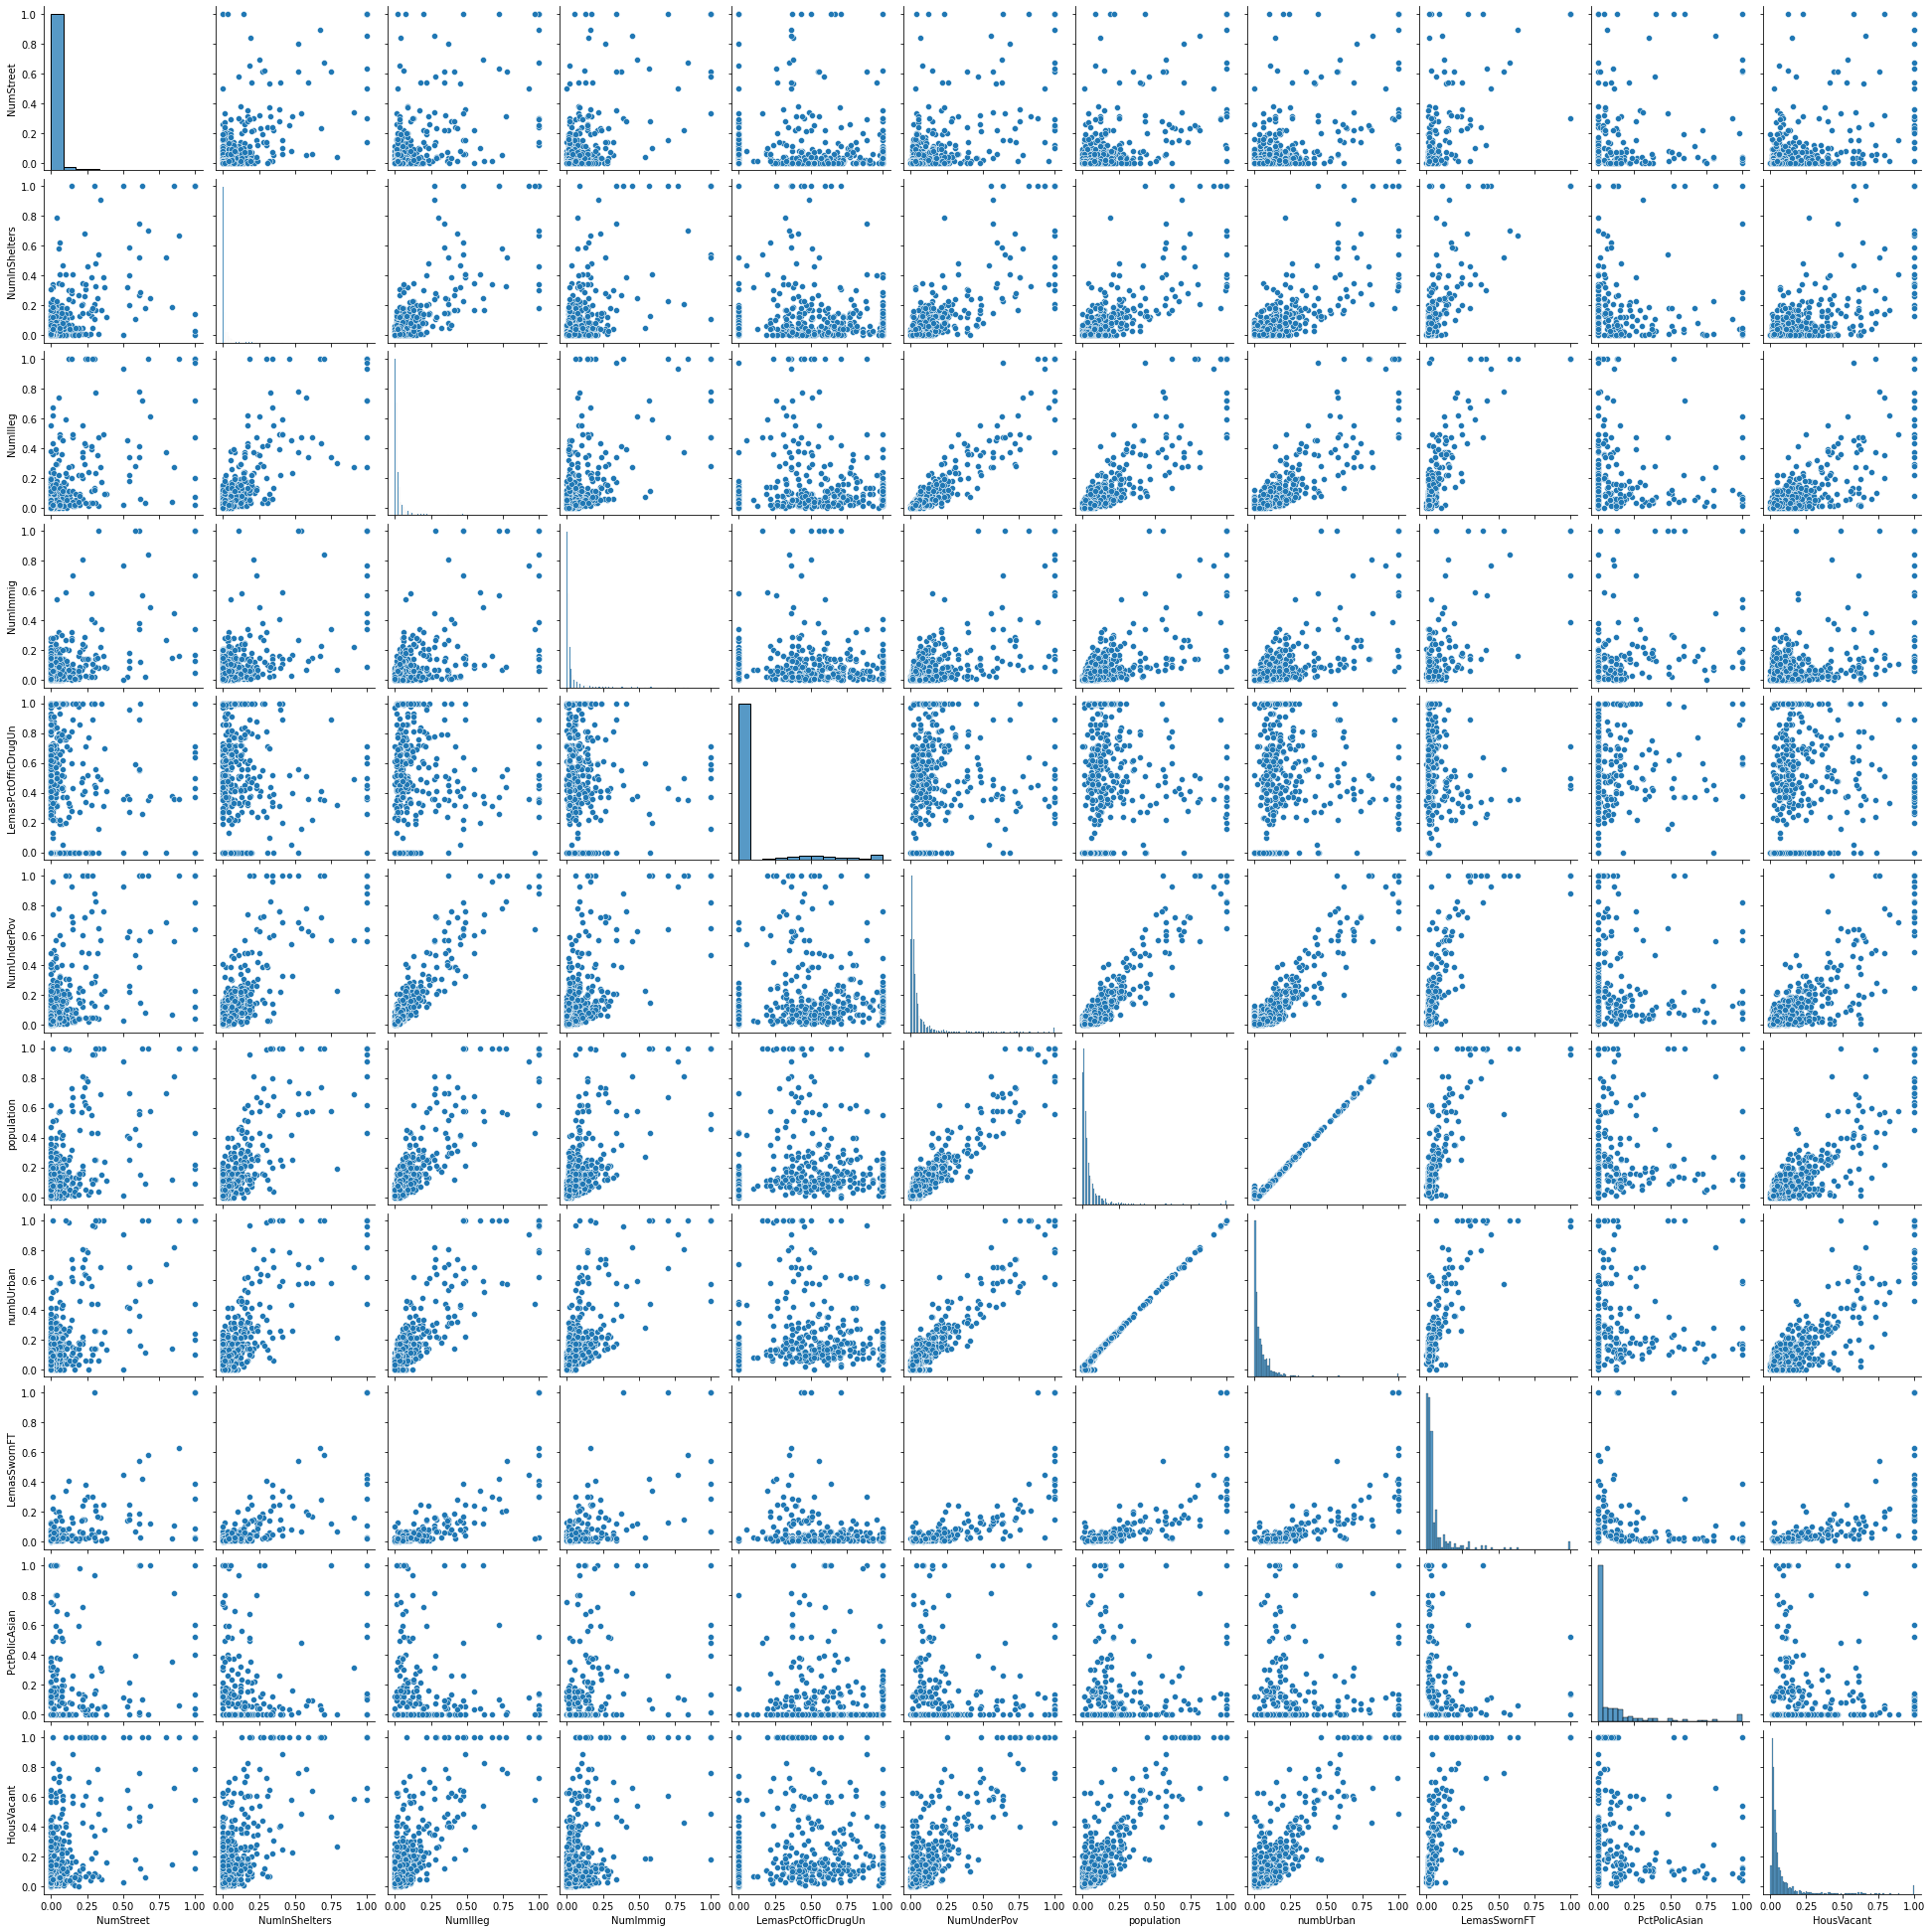

In [9]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html

pairplot = sns.pairplot(communities_df[highestCV_attrL], kind="scatter")
# increasing axis label size
plt.rcParams["axes.labelsize"] = 24

plt.show()


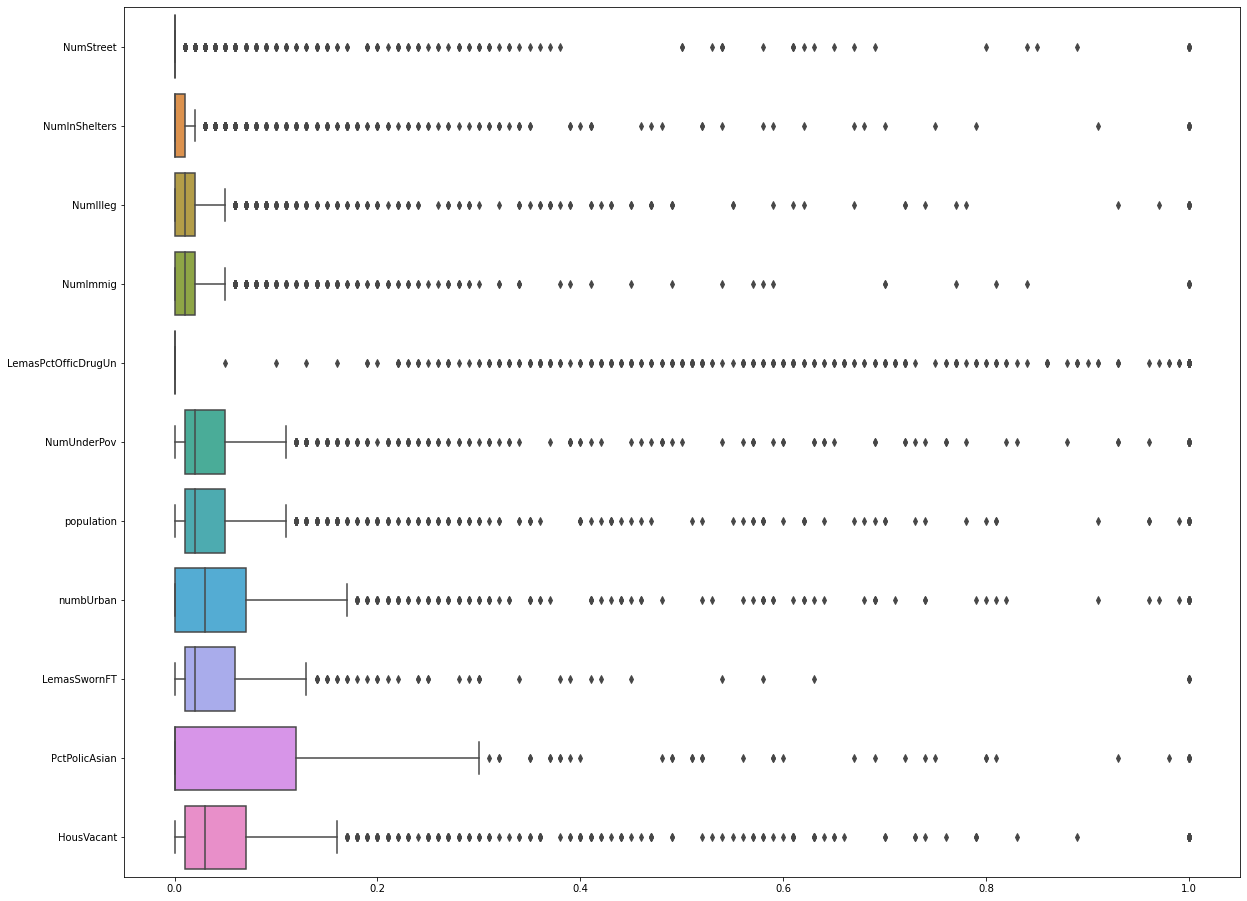

In [10]:


fig, ax = plt.subplots(figsize=(20, 16))
boxplot = sns.boxplot(data=communities_df[highestCV_attrL], orient="h", ax=ax)
# plt.xticks(rotation=30)
plt.rcParams["axes.labelsize"] = 22

plt.show()

# The data point outside the min-max range are outliers per the IQR method --  > Q3 + 1.5*IQR


No. It appear that drawing a conclusion of feature significance just from these distribution visualizations doesn't seem tenable. Most of the scatterplots appears to have very low correlations with each other, with little to no distinguishable trends. The only scatterplot with a clear relationship is "population" and "numbUrban" which have a practically 1:1 positive linear correlation. This might suggest multicollinearity more so than significance. If I were to venture any guess about feature significance based on the boxplot, I would most think that "PctPolicAsian" could be informative since it's distribution is relatively distinct from the rest (and varied).

---------------
## 1.f

Fit a linear model using least squares to the training set and report the test error.

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

# I am using the sklearn regression algorithm -- rather than the statsmodels version -- since we don't need an output summary now

# creating OLS linear regression model

# The "communities_names" file mentions the the response/goal variable is ViolentCrimesPerPop
# Since, the assignment prompt doesn't state otherwise, I will model based on this

trainX = train_df.iloc[:, :-1]
# The data is already normalized; now we just scale/standardize it
scaled_trainX = scale(train_df.iloc[:, :-1])
trainY = train_df.iloc[:, -1]

testX = test_df.iloc[:, :-1]
scaled_testX = scale(test_df.iloc[:, :-1])
testY = test_df.iloc[:, -1]

ols_model = LinearRegression()
ols_model.fit(trainX, trainY)

prediction = ols_model.predict(testX)
mse = mean_squared_error(testY, prediction)

print("OLS Linear Regression\nTest MSE:", mse)


OLS Linear Regression
Test MSE: 0.01814197113553011


---------------
## 1.g

Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV.predict
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

# the penalty coefficient λ can be configured through the alpha parameter 
# In other words, the λ we are choosing through cv, is the alpha

# range of possible alphas
alphas = (0.0001, 0.001, 0.01, 0.1, 1, 10, 100)

folds = KFold(5, shuffle=True, random_state=1)
# sklearn document refers to this as the "cv splitter"

# This algorithm automatically uses the best alpha, from the passed argument array, based on the cross-validation
ridgeCV_model = RidgeCV(alphas=alphas, cv=folds, scoring="neg_mean_squared_error")
ridgeCV_model.fit(trainX, trainY)

# the "alpha_" attribute gives the penalty coefficient λ with the highest mse score based on the cv
best_alpha = ridgeCV_model.alpha_

prediction = ridgeCV_model.predict(testX)
mse = mean_squared_error(testY, prediction)

print("Ridge Regression: with a penalty coefficeint (λ) of alpha =", best_alpha, "-- chosen from 5-fold CV")
print("Test MSE:", mse)


Ridge Regression: with a penalty coefficeint (λ) of alpha = 1.0 -- chosen from 5-fold CV
Test MSE: 0.01773247499289664


---------------
## 1.h

Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html


# This algorithm automatically uses the best alpha, from the passed argument array, based on the cross-validation
lassoCV_model = LassoCV(alphas=alphas, cv=folds)
lassoCV_model.fit(trainX, trainY)

# the "alpha_" attribute gives the penalty coefficient λ with the highest mse score based on the cv
best_alpha = lassoCV_model.alpha_

prediction = lassoCV_model.predict(testX)
mse = mean_squared_error(testY, prediction)

print("Lasso Regression: with a penalty coefficeint (λ) of alpha =", best_alpha, "-- chosen from 5-fold CV")
print("Test MSE:", mse)


attr_coefL = []
# The purpose of imposing penalty λ, is to reduce (i.e. shrink) the feature coefficient values towards zero -- and subsequently remove said features 
# Coefficients that are 0 have been dropped out of the model.
# So, we can report the list of the variables selected by the model the following way
print("\n\nList of the variables selected by the model")
n = 1
for attr, coef in zip(attrL[:-1], lassoCV_model.coef_):
    if float(coef) != 0.0:
        attr_coefL.append((attr, coef))
#         print(n, attr, ">>>", coef)
        n +=1
# Since the best alpha is basically 0, we automatically know that no features were removes here
# Also, there used to be a "feature_names_in_" that did this automatically; looks like it has been removed

attr_coef_df = pd.DataFrame(attr_coefL, columns=(("Feature", "Coefficient")))
display(attr_coef_df)


Lasso Regression: with a penalty coefficeint (λ) of alpha = 0.0001 -- chosen from 5-fold CV
Test MSE: 0.01778608951910212


List of the variables selected by the model


Feature  Coefficient
0          racepctblack     0.273052
1          racePctAsian    -0.017982
2           agePct12t21     0.076001
3           agePct12t29    -0.291125
4            agePct65up     0.003873
..                  ...          ...
73       PctUsePubTrans    -0.047532
74            PolicCars     0.000543
75  LemasPctPolicOnPatr     0.021727
76  LemasGangUnitDeploy     0.040690
77  LemasPctOfficDrugUn     0.000618

[78 rows x 2 columns]

In [14]:
lassoCV_model.fit(scaled_trainX, trainY)

best_alpha = lassoCV_model.alpha_

prediction = lassoCV_model.predict(scaled_testX)
mse = mean_squared_error(testY, prediction)

print("Lasso Regression: with a penalty coefficeint (λ) of alpha =", best_alpha, "-- chosen from 5-fold CV")
print("Test MSE:", mse)


# import warnings
warnings.filterwarnings("ignore")
# ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

attr_coefL = []
# The consequence of imposing penalty λ, is to reduce (i.e. shrink) the feature coefficient values towards zero -- and subsequently remove said features 
# Coefficients that are 0 have been dropped out of the model.
# So, we can report the list of the variables selected by the model the following way
print("\n\nList of the variables selected by the model")
n = 1
for attr, coef in zip(attrL[:-1], lassoCV_model.coef_):
    if float(coef) != 0.0:
        attr_coefL.append((attr, coef))
#         print(n, attr, ">>>", coef)
        n +=1
# Since the best alpha is basically 0, we automatically know that no features were removes here
# Also, there used to be a "feature_names_in_" that did this automatically; looks like it has been removed

attr_coef_df = pd.DataFrame(attr_coefL, columns=(("Feature", "Coefficient")))
display(attr_coef_df)


Lasso Regression: with a penalty coefficeint (λ) of alpha = 0.001 -- chosen from 5-fold CV
Test MSE: 0.017949170546600612


List of the variables selected by the model


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02002938195459336, tolerance: 0.006748973010033445
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15965476802144707, tolerance: 0.006878343503344482
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06448091682221246, tolerance: 0.006841585117056858
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.8/site-packages/

Feature  Coefficient
0          racepctblack     0.066805
1           agePct12t21     0.005265
2           agePct12t29    -0.028572
3              pctUrban     0.015660
4              pctWWage    -0.008793
..                  ...          ...
63              PopDens     0.002540
64       PctUsePubTrans    -0.007038
65            PolicCars     0.002432
66  LemasPctPolicOnPatr     0.002066
67  LemasGangUnitDeploy     0.006239

[68 rows x 2 columns]

---------------
## 1.i

Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
# from sklearn.model_selection import cross_val_score

# There is no algorithm for PCR specifically, so we need to use a combination of PCA and LinearRegression
# from sklearn.decomposition import PCA

# range of M (number of principle components)
mL = list(range(1, len(attrL), 1))

# list of the results MSE from all the PCR 5-fold cross-validations for the varying "M"s
mseL = []
for m in mL:

    # using as the same k-fold splitter as before: folds = KFold(5, shuffle=True, random_state=1)

    pca = PCA(n_components=m)

    # The PCA model doesn't have a cv attribute for the (kfold) splitter
    # So we need to apply cross-validation manually


    pca_trainX = pca.fit_transform(trainX)

    ols_model = LinearRegression()

    # getting the mean of each fold interation's MSE
    mse = -1*cross_val_score(ols_model, pca_trainX, trainY, cv=folds, scoring="neg_mean_squared_error").mean()
    
    mseL.append(mse)
#     print(mse)

# this M gives the lowest cross-validation error score
bestM = mseL.index(min(mseL))
# print(min(mseL), mseL.index(min(mseL)))

pca = PCA(n_components=bestM)
pca.fit(trainX)
pca_trainX = pca.transform(trainX)
pca_testX = pca.transform(testX)

# display(pca_trainX.shape)

ols_model.fit(pca_trainX, trainY)
prediction = ols_model.predict(pca_testX)

mse = mean_squared_error(testY, prediction)

print("Principal Component Regression: with (the number of principal components) M =", bestM, "-- chosen from 5-fold CV")
print("Test MSE:", mse)


Principal Component Regression: with (the number of principal components) M = 95 -- chosen from 5-fold CV
Test MSE: 0.018489888126200206


---------------
## 1.j

In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost3 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [16]:
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html
# https://xgboost.readthedocs.io/en/latest/parameter.html

# # converting data to Data Matrix format
# train_dm = xgb.DMatrix(data=trainX, label=trainY)
# test_dm = xgb.DMatrix(data=testX)

# just as in the previous questions, we are using the same (previously defined) alphas range and cross validation (k-fold) splitter 

mseL = []
for alpha in alphas:
    # reg_alpha is the L1 regularization/penalty term on weights; reg_lambda is the L2 regularization/penalty term on weights
    # We are told to use L1, so we use reg_alpha parameter
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", reg_alpha=alpha)
    mse = -1*cross_val_score(xgb_model, trainX, trainY, cv=folds, scoring="neg_mean_squared_error").mean()
    
    mseL.append(mse)

# this gives the alpha with lowest cross-validation error score
best_alpha = alphas[mseL.index(min(mseL))]


# training our XGBoost model with the alpha determined from cross validation
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=best_alpha)
xgb_model.fit(trainX, trainY)

prediction = xgb_model.predict(testX)
mse = mean_squared_error(testY, prediction)

print("L1 Penalized Gradient Boosting Tree: with regularization term (ie penalty coefficeint) of α =", best_alpha, "-- chosen from 5-fold CV")
print("Test MSE:", mse)

# Just like for the other models, by using different randomizations (i.e. random_states), the best alpha and overall results vary


L1 Penalized Gradient Boosting Tree: with regularization term (ie penalty coefficeint) of α = 0.0001 -- chosen from 5-fold CV
Test MSE: 0.018487463405660143


------------
## Tree-Based Methods
## 2.a 
Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. 

The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [17]:
aps_train_file = "../data/aps_failure_training_set.csv"
aps_test_file = "../data/aps_failure_test_set.csv"

# The first 20 lines of the csv files contains general information -- such as about license/copyright
aps_train_df_raw = pd.read_csv(aps_train_file, skiprows=20, na_values = "na")
aps_test_df_raw = pd.read_csv(aps_test_file, skiprows=20, na_values = "na")

display(aps_train_df_raw)
display(aps_test_df_raw)

class  aa_000  ab_000        ac_000  ad_000  ...    ee_007    ee_008  \
0       neg   76698     NaN  2.130706e+09   280.0  ...  157956.0   73224.0   
1       neg   33058     NaN  0.000000e+00     NaN  ...   81140.0   97576.0   
2       neg   41040     NaN  2.280000e+02   100.0  ...  158022.0   95128.0   
3       neg      12     0.0  7.000000e+01    66.0  ...       0.0       0.0   
4       neg   60874     NaN  1.368000e+03   458.0  ...  311560.0  433954.0   
...     ...     ...     ...           ...     ...  ...       ...       ...   
59995   neg  153002     NaN  6.640000e+02   186.0  ...  717762.0  898642.0   
59996   neg    2286     NaN  2.130707e+09   224.0  ...       0.0       0.0   
59997   neg     112     0.0  2.130706e+09    18.0  ...    2622.0       0.0   
59998   neg   80292     NaN  2.130706e+09   494.0  ...  165070.0  802280.0   
59999   neg   40222     NaN  6.980000e+02   628.0  ...  158304.0  170384.0   

         ee_009  ef_000  eg_000  
0           0.0     0.0     0.0  
1        1500.0     0.0     0.0  
2         514.0     0.0     0.0  
3           0.0     4.0    32.0  
4        1218.0     0.0     0.0  
...         ...     ...     ...  
59995   28588.0     0.0     0.0  
59996       0.0     0.0     0.0  
59997       0.0     0.0     0.0  
59998  388422.0     0.0     0.0  
59999     158.0     0.0     0.0  

[60000 rows x 171 columns]

class  aa_000  ab_000        ac_000  ad_000  ...    ee_007    ee_008  \
0       neg      60     0.0  2.000000e+01    12.0  ...      88.0       0.0   
1       neg      82     0.0  6.800000e+01    40.0  ...     462.0       0.0   
2       neg   66002     2.0  2.120000e+02   112.0  ...  153680.0     516.0   
3       neg   59816     NaN  1.010000e+03   936.0  ...  210074.0  281662.0   
4       neg    1814     NaN  1.560000e+02   140.0  ...     482.0      76.0   
...     ...     ...     ...           ...     ...  ...       ...       ...   
15995   neg   81852     NaN  2.130706e+09   892.0  ...  317840.0  960024.0   
15996   neg      18     0.0  5.200000e+01    46.0  ...       0.0       0.0   
15997   neg   79636     NaN  1.670000e+03  1518.0  ...  222866.0  358934.0   
15998   neg     110     NaN  3.600000e+01    32.0  ...    1338.0      74.0   
15999   neg       8     0.0  6.000000e+00     4.0  ...      46.0       0.0   

        ee_009  ef_000  eg_000  
0          0.0     0.0     0.0  
1          0.0     0.0     0.0  
2          0.0     0.0     0.0  
3       3232.0     0.0     0.0  
4          0.0     0.0     0.0  
...        ...     ...     ...  
15995  25566.0     0.0     0.0  
15996      0.0     0.0     0.0  
15997  19548.0     0.0     0.0  
15998      0.0     0.0     0.0  
15999      0.0     0.0     0.0  

[16000 rows x 171 columns]

------------
## 2.b.i

Data Preparation <br>
This data set has missing values. When the number of data with missing values
is significant, discarding them is not a good idea.

i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [18]:
# https://scikit-learn.org/stable/modules/impute.html 
# https://www.theanalysisfactor.com/seven-ways-to-make-up-data-common-methods-to-imputing-missing-data/

There are many different types of imputation. First, it can be divided into single/univariate or multiple/multivariate imputation. "Single refers to the fact that you come up with a single estimate of the missing value, using one of the seven methods listed above." Univariate option imputes values for a certain feature using only non-missing values in that very feature; popular estimates for the feature data used for single imputation are mean, median, and mode. With sklearn, we can use the SimpleImputer to do this. Conversely, multivariate imputation uses the entire set of available features to estimate the missing values -- for example using regression for a quantitative attribute. Sklearn's IterativeImputer can be used for this. While usually, multivariate impuation has shown to be more effective, this option is also more complex and time consuming -- which isn't the best choice for our already complex, long-running model. So, we will apply univariate imputation. A common choice is the mean. However, as we will later see, this dataset's feature distributions are extremely skewed with many outliers. The mean estimate is very strongly affected by outliers, so it wouldn't be reliable. Instead, be will use median imputation for our missing values.


In [19]:
# joining the train+test sets to create our total dataset

# We use the axis=0 parameter to indicate that it is the rows of the DFs that are being joined together.
aps_total_df_raw = pd.concat([aps_train_df_raw, aps_test_df_raw], ignore_index=True, axis=0)

# Unlike in 1.b where we train the imputer on the train set and and use it to also impute the test set, footnote 4 tells us to impute the whole dataset all together
# as mentioned, for simplicity, we will use the median imputation method since it is a computationally efficient, viable option 
# We later see that this data has very skewed distribution; mean would be affected too much
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# before we do median imputation, we should seperate the quantitative features (X) from the categorical response variable (Y) -- which doesn't have missing values
aps_totalY_df = aps_total_df_raw.iloc[:, 0]
aps_totalX_df_raw = aps_total_df_raw.iloc[:, 1:]

# Fit to the total dataset, then transform/impute it
imputed_totalX_data = imputer.fit_transform(aps_totalX_df_raw)

colL = list(aps_total_df_raw.columns)
attrL = colL[1:]

aps_totalX_df = pd.DataFrame(imputed_totalX_data, columns=attrL)
display(aps_totalX_df)


aa_000  ab_000        ac_000  ad_000  ae_000  ...    ee_007    ee_008  \
0      76698.0     0.0  2.130706e+09   280.0     0.0  ...  157956.0   73224.0   
1      33058.0     0.0  0.000000e+00   128.0     0.0  ...   81140.0   97576.0   
2      41040.0     0.0  2.280000e+02   100.0     0.0  ...  158022.0   95128.0   
3         12.0     0.0  7.000000e+01    66.0     0.0  ...       0.0       0.0   
4      60874.0     0.0  1.368000e+03   458.0     0.0  ...  311560.0  433954.0   
...        ...     ...           ...     ...     ...  ...       ...       ...   
75995  81852.0     0.0  2.130706e+09   892.0     0.0  ...  317840.0  960024.0   
75996     18.0     0.0  5.200000e+01    46.0     8.0  ...       0.0       0.0   
75997  79636.0     0.0  1.670000e+03  1518.0     0.0  ...  222866.0  358934.0   
75998    110.0     0.0  3.600000e+01    32.0     0.0  ...    1338.0      74.0   
75999      8.0     0.0  6.000000e+00     4.0     2.0  ...      46.0       0.0   

        ee_009  ef_000  eg_000  
0          0.0     0.0     0.0  
1       1500.0     0.0     0.0  
2        514.0     0.0     0.0  
3          0.0     4.0    32.0  
4       1218.0     0.0     0.0  
...        ...     ...     ...  
75995  25566.0     0.0     0.0  
75996      0.0     0.0     0.0  
75997  19548.0     0.0     0.0  
75998      0.0     0.0     0.0  
75999      0.0     0.0     0.0  

[76000 rows x 170 columns]

------------
## 2.b.ii

Data Preparation

ii. For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.

In [20]:
# like 1.d

cvL = []

for attr in attrL:
    
    cv = aps_totalX_df[attr].std()/aps_totalX_df[attr].mean()
    cvL.append((attr, cv))

cv_df = pd.DataFrame(cvL, columns=(("Features", "CV")))
# print(cvL)
display(cv_df)

Features          CV
0     aa_000    4.328608
1     ab_000    9.740521
2     ac_000    2.309299
3     ad_000  274.790378
4     ae_000   23.271357
..       ...         ...
165   ee_007    4.935380
166   ee_008    3.373881
167   ee_009    5.821008
168   ef_000   50.223681
169   eg_000   47.845392

[170 rows x 2 columns]

------------
## 2.b.iii

Data Preparation <br>

iii. Plot a correlation matrix for your features using pandas or any other tool.

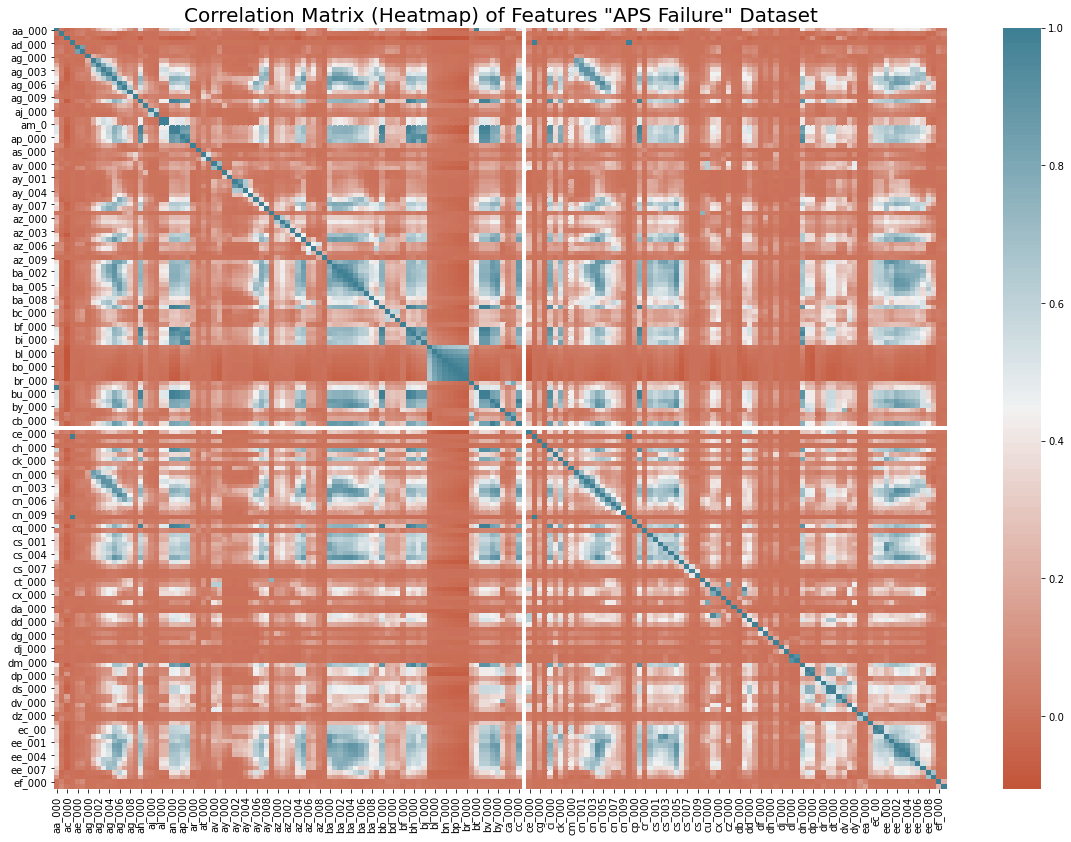

In [21]:
# like 1.c

# can uncommment the line below, to see all attribute names -- for reference
# print(attrL)

fig, ax = plt.subplots(figsize=(20, 14))
corr = aps_totalX_df.corr()
heatmap = sns.heatmap(corr,cmap=sns.diverging_palette(20, 220, n=200), ax=ax)
# Only every third feature name is written on the axes -- due to not enough space
# It shouldn't matter though, since all of them are visualized nonetheless
plt.title("Correlation Matrix (Heatmap) of Features \"APS Failure\" Dataset", fontsize=20)

plt.show()


------------
## 2.b.iv

Data Preparation <br>

iv. Pick ⌊170⌋ features with highest CV , and make scatter plots and box plots
for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [22]:
# like 1.e

# The floor of √170 is just rounding down

# We use the "key" parameter to sort by the second tuple element
# lambda creates a mini-function
cvL.sort(reverse=True, key=lambda x:x[1])
# We used the cvL created in b.ii

highest_cvL = cvL[:int(math.sqrt(170))]
# print(highest_cvL)

highestCV_attrL = [attr for attr, cv in highest_cvL]


class  cf_000  co_000  ad_000  cs_009  ...  ag_000  au_000  ak_000  \
0       neg     2.0   220.0   280.0     0.0  ...     0.0     0.0     0.0   
1       neg     2.0     8.0   128.0     0.0  ...     0.0     0.0     0.0   
2       neg     0.0     0.0   100.0     0.0  ...     0.0     0.0     0.0   
3       neg     2.0     2.0    66.0     0.0  ...     0.0     0.0     0.0   
4       neg     0.0   202.0   458.0     0.0  ...     0.0     0.0     0.0   
...     ...     ...     ...     ...     ...  ...     ...     ...     ...   
75995   neg     2.0    42.0   892.0     0.0  ...     0.0     0.0     0.0   
75996   neg     2.0     0.0    46.0     0.0  ...     0.0     0.0     0.0   
75997   neg     2.0   378.0  1518.0     0.0  ...     0.0     0.0     0.0   
75998   neg     0.0     0.0    32.0     0.0  ...     0.0     0.0     0.0   
75999   neg     0.0     0.0     4.0     0.0  ...     0.0     0.0     0.0   

       az_009  ay_009  
0         0.0     0.0  
1         0.0     0.0  
2         0.0     0.0  
3         0.0     0.0  
4         0.0     0.0  
...       ...     ...  
75995     0.0     0.0  
75996     0.0     0.0  
75997     0.0     0.0  
75998     0.0     0.0  
75999     0.0     0.0  

[76000 rows x 14 columns]

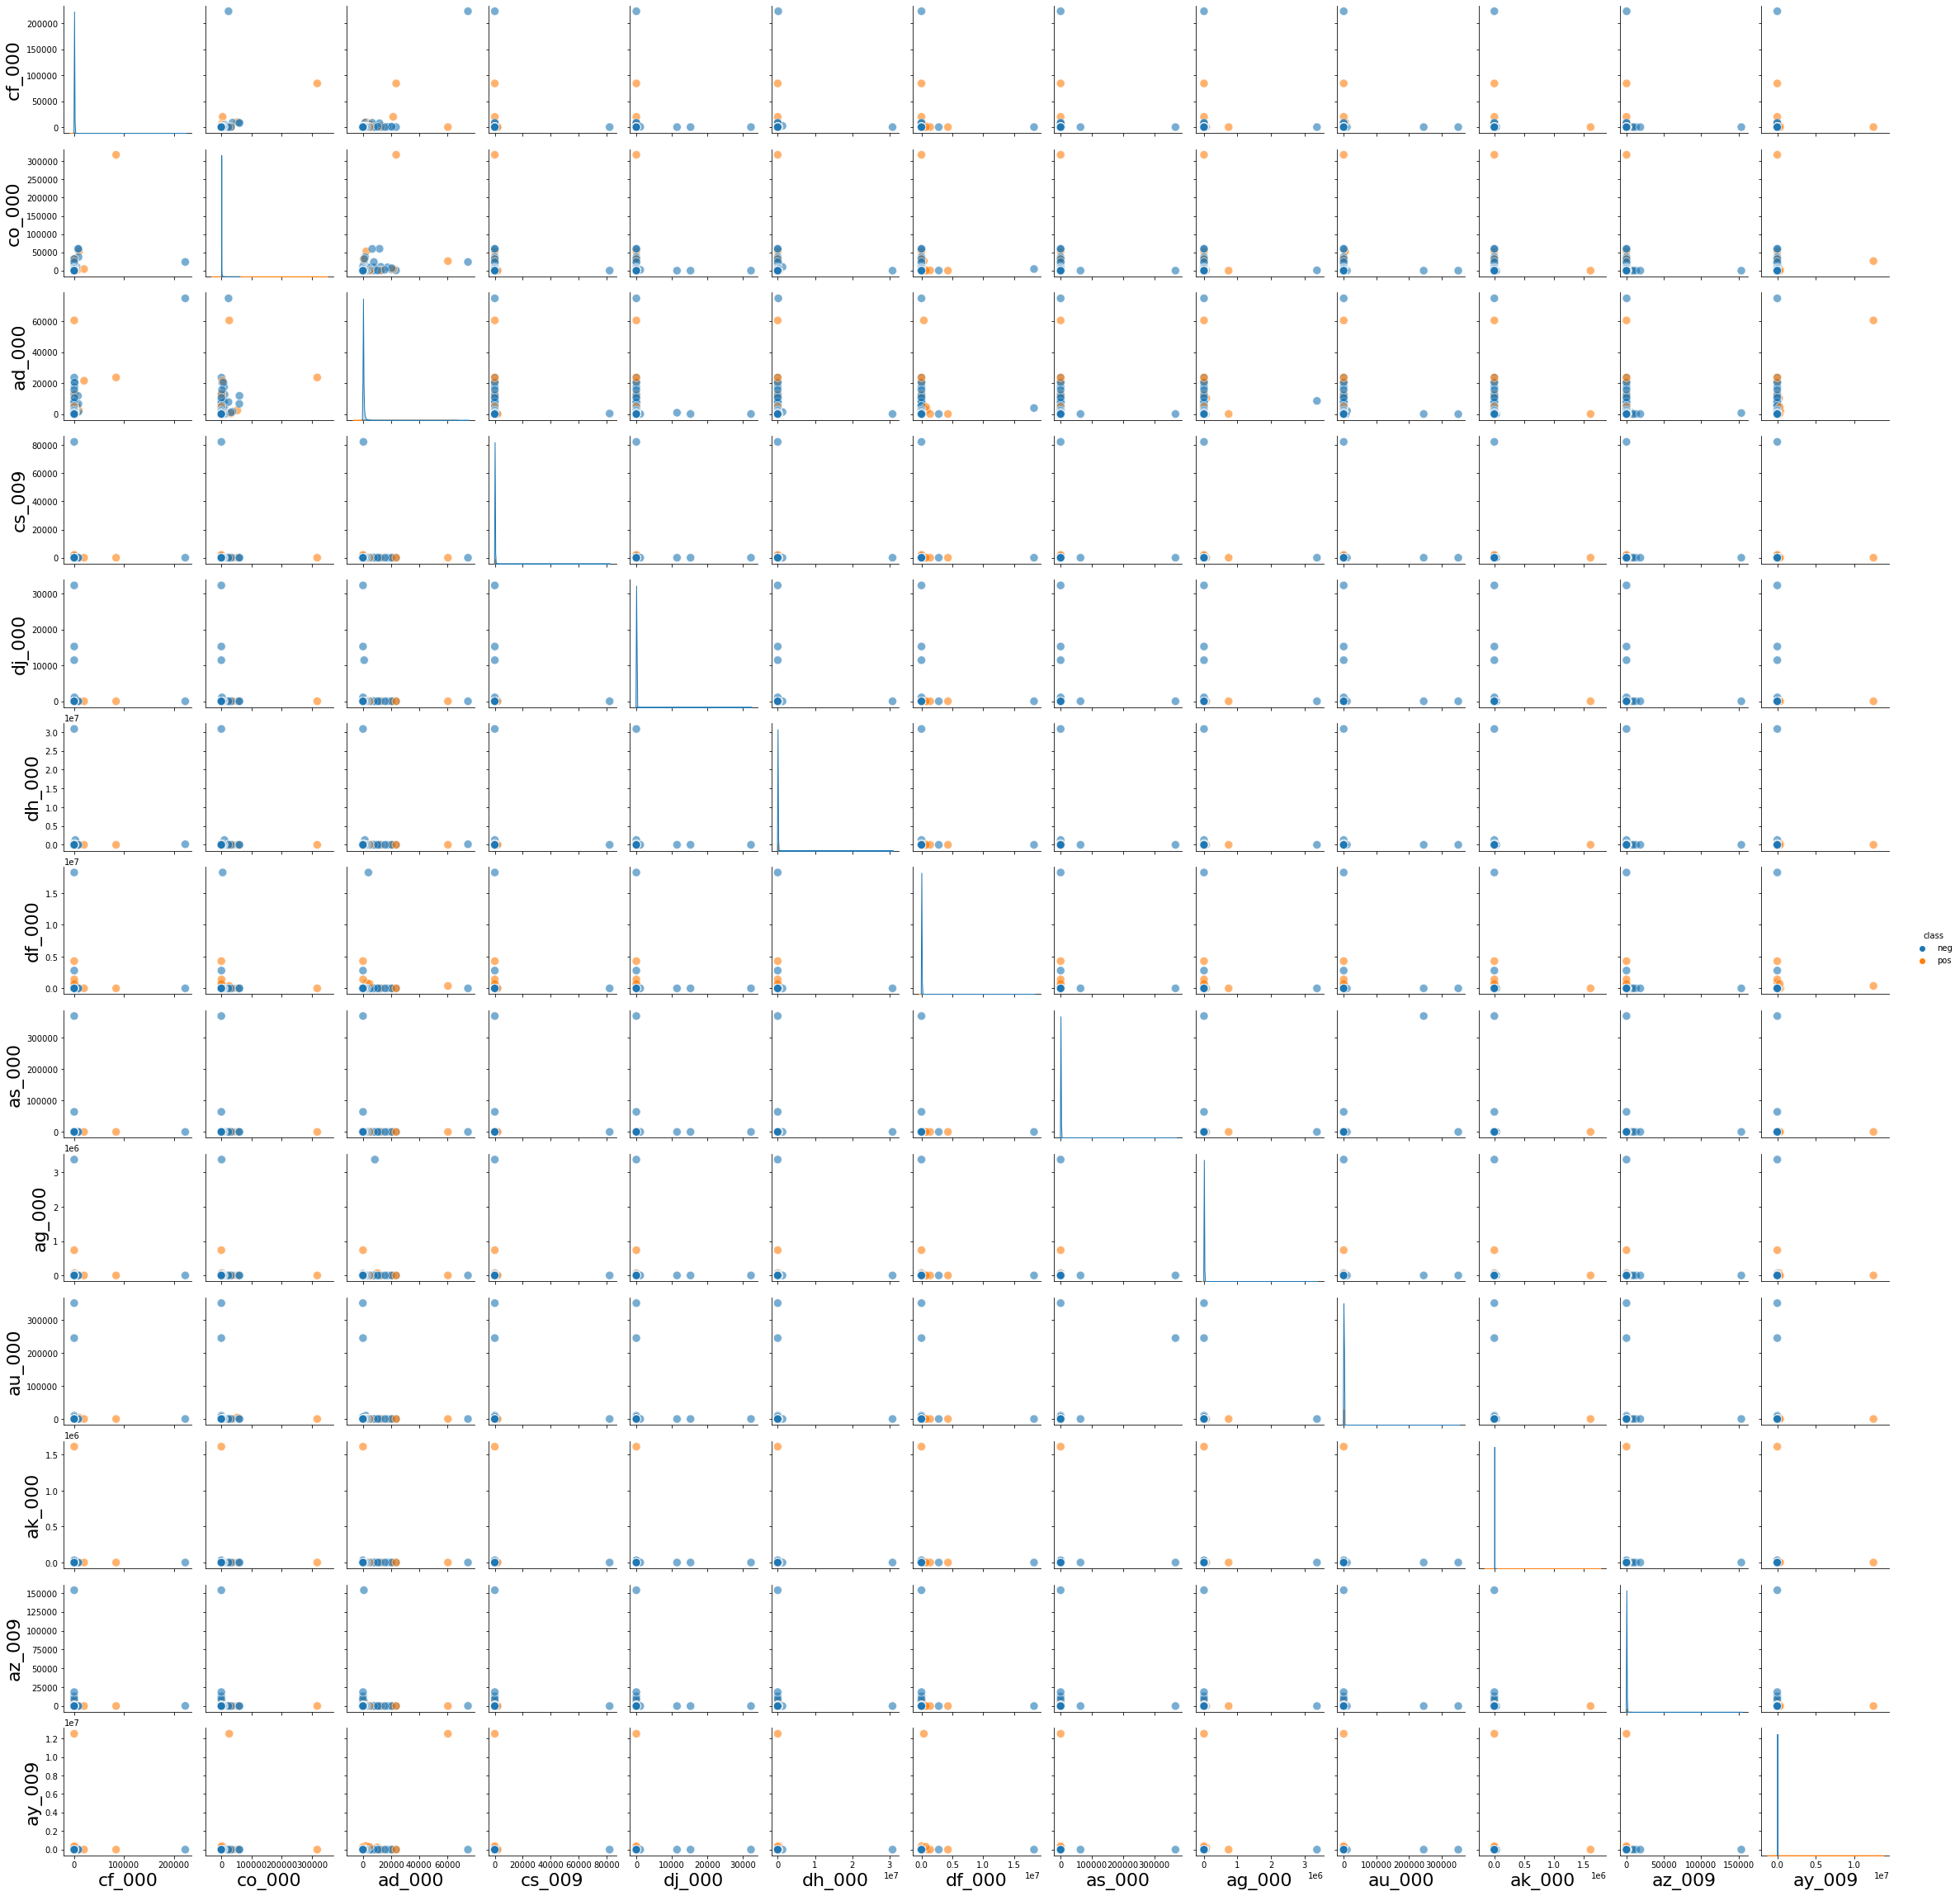

In [23]:
# We use the axis=1 parameter to indicate that it is the columns of the DFs that are being joined together.
selected_total_df = pd.concat([aps_totalY_df, aps_totalX_df[highestCV_attrL]], axis=1)
display(selected_total_df)

# Per TA's recommendation, we downsample to 10%, to decrease the run time for the scatterplot matrix; 
# More importantly, without using the samller  portion of the dataset, the kernal just kept crashing/dying; scatterplot matrix is esspecially burdensome to run/visualize
# Keep in mind it still takes quite a long time to load
pairplot = sns.pairplot(selected_total_df.sample(frac=0.1, random_state=1), kind="scatter", hue="class", plot_kws={"s": 100, "alpha":0.6})
# increasing axis label size
plt.rcParams["axes.labelsize"] = 24

plt.show()

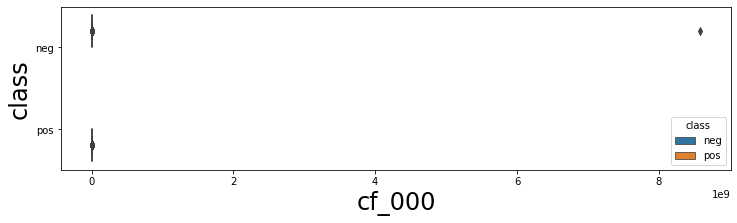

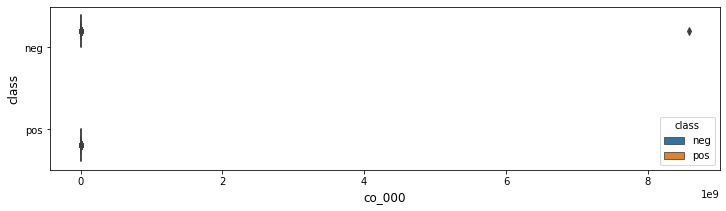

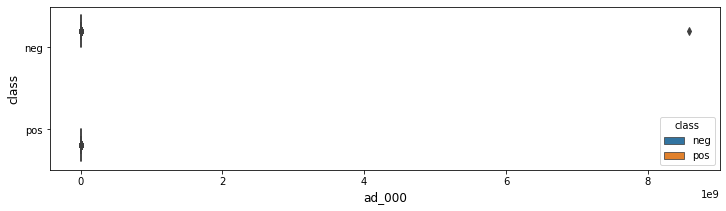

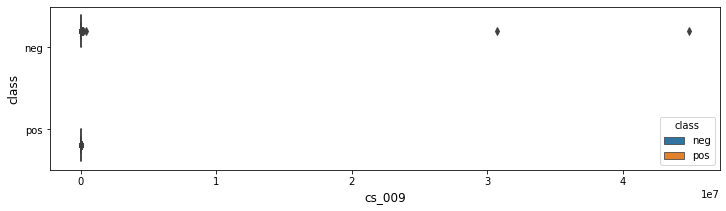

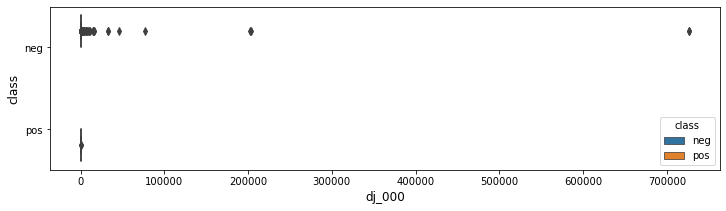

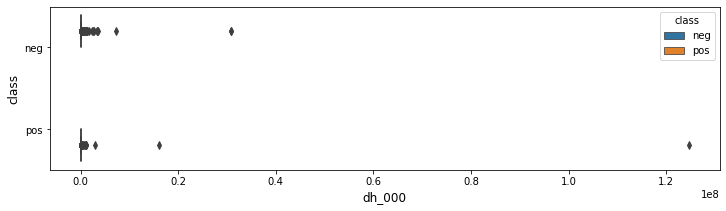

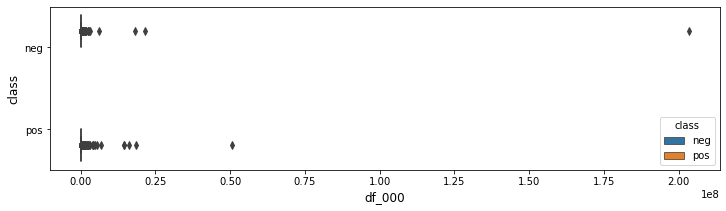

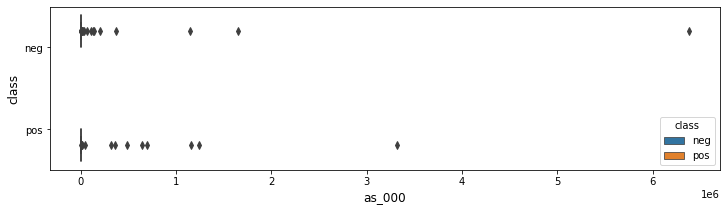

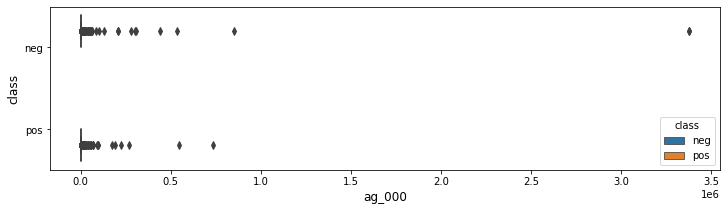

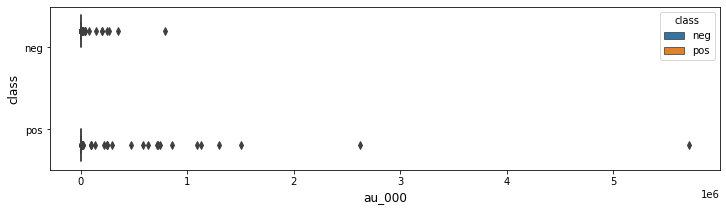

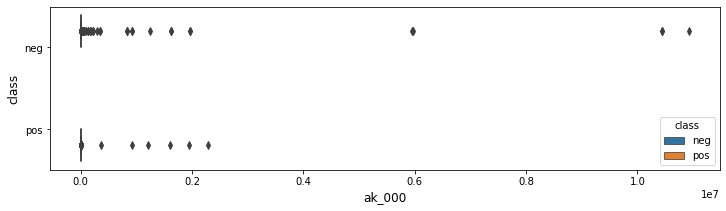

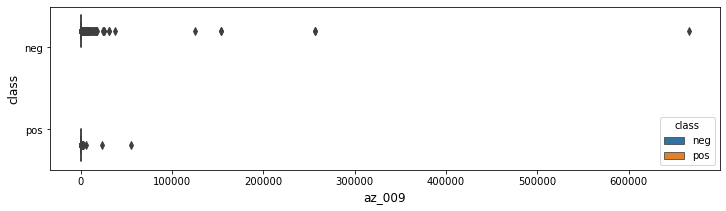

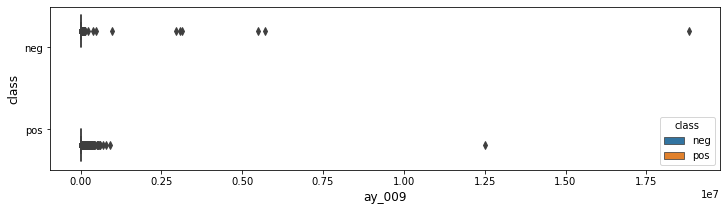

In [24]:
for attr in highestCV_attrL:
    fig, ax = plt.subplots(figsize=(12, 3))
    # I visually understand horizontally orriented boxplots better
    boxplot = sns.boxplot(x=attr, y="class", hue="class", data=selected_total_df, orient="h", ax=ax)
    
    plt.rcParams["axes.labelsize"] = 12
    plt.show()
    print()

# The data points outside the min-max range are outliers per the IQR method --  > Q3 + 1.5*IQR


Feature Boxplots after Log-Transformation


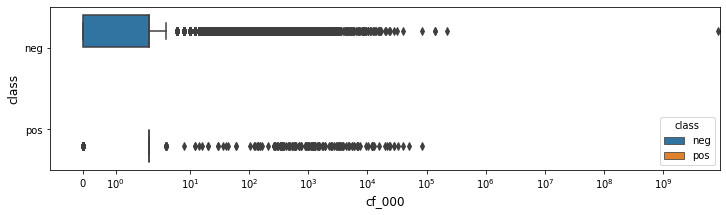

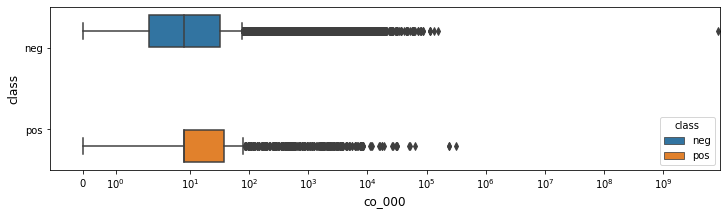

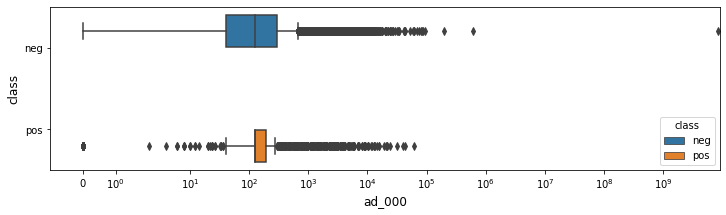

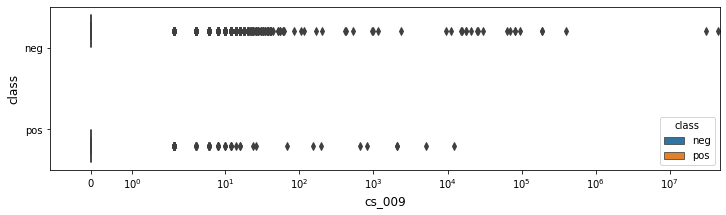

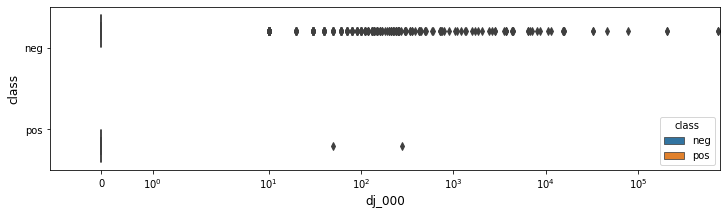

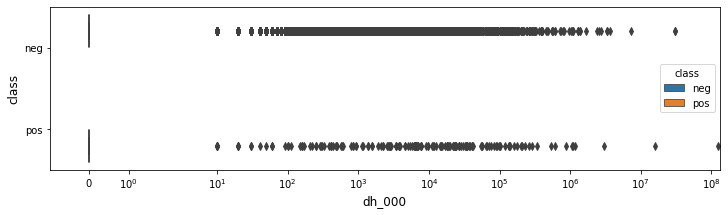

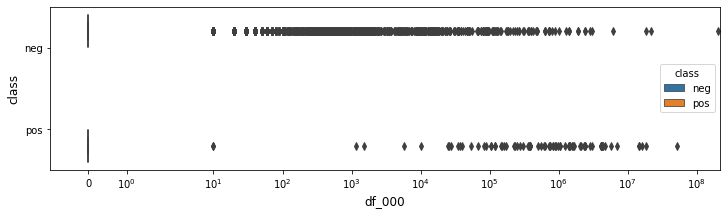

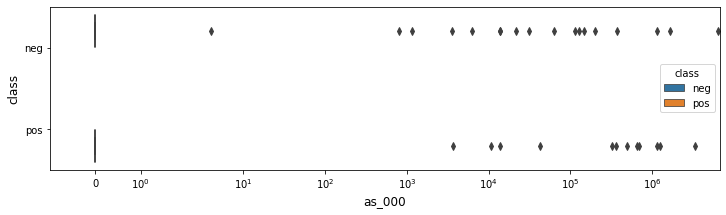

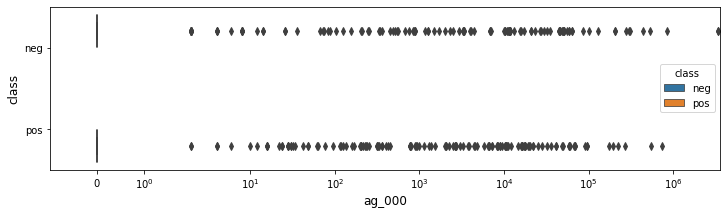

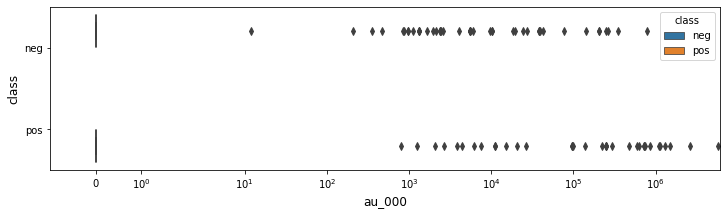

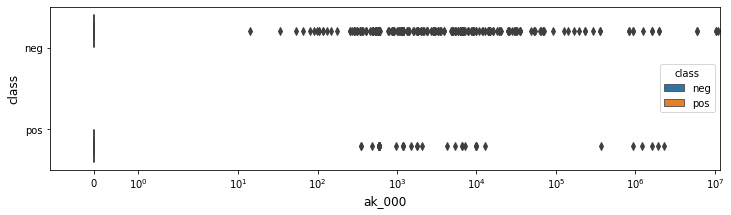

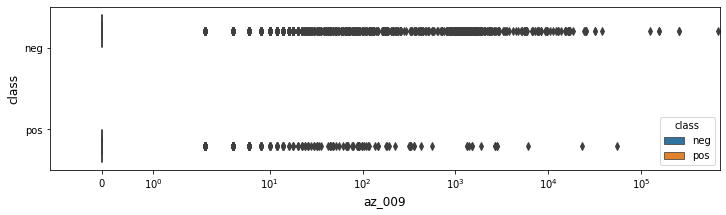

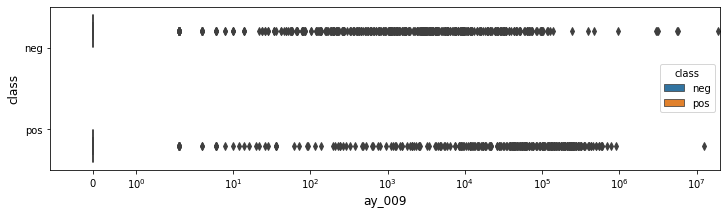

In [25]:
# Since the boxplots above aren't very informative due to the extreme skew, so we use log for the xscale (of our feature vals)

print("Feature Boxplots after Log-Transformation")

for attr in highestCV_attrL:
    fig, ax = plt.subplots(figsize=(12, 3))
    # I visually understand horizontally orriented boxplots better
    boxplot = sns.boxplot(x=attr, y="class", hue="class", data=selected_total_df, orient="h", ax=ax)
    # The distribution is imbalanced with a significant right skew; so we can log transfrom the feature values for better visualization
    boxplot.set(xscale="symlog")
    
    ax.set_xlim(xmin=-1)
    
    plt.rcParams["axes.labelsize"] = 12
    plt.show()
    
    print()

# The data points outside the min-max range are outliers per the IQR method --  > Q3 + 1.5*IQR

# We see that even like this, there are a lot of "outliers" per IQR; and the distributions are still very right skewed

Firstly, as mentioned at the start of 2, a mean imputation strategy would be too greatly affected by these very "outlier". That earlier claim is supported by these boxplots. The distribution skew is so extreme the original boxplot aren't even readable. So, we use the log scale to better see/understand the distributions. Although still not amazing, it is clearly better.

In general, it is still rather difficult to draw conclusions about feature significance (for classification) from this. However, we clearly see that the first three have more reasonable distributions. So, firstly, a case could be made that they will be more compatible with most models. However, we can see that the boxplots for their two classes have a lot of overlap, which would mean they wouldn't be too significant. On the other hand, the other features are so skewed, it looks like like the majority of their values (shown by the box and whiskers) are ~0. This is the case for both the positive and negative class; this is a very high level of overlap which isn't useful for classification. I wouldn't think they would be very significant.

>So, overall, since the boxplots of the first three have a relatively much more distinct clas distribution, they should be more effective predictors for classification. Therefore, we can draw the conclusion that "cf_000", "co_000", and "ad_000" would likely be more significant than the other ones features. This is also supported by the scatterplot matrix relationship/correlations.

------------
## 2.b.v

Data Preparation <br>

v. Determine the number of positive and negative data. Is this data set imbalanced?

In [26]:
print("Total Dataset\n-------------\n" + str(aps_totalY_df.value_counts())[:-25])


# The lines of code aren't necessarily for this subquestions; but we can also show the imbalance more specifically for the train/test sets
# So, we need to redivide the total dataset

# We use the axis=1 parameter to indicate that it is the columns of the DFs that are being joined together.
aps_total_df = pd.concat([aps_totalY_df, aps_totalX_df], axis=1)

aps_train_df = aps_total_df.iloc[:60000]
# display(aps_train_df)
aps_trainY_df = aps_train_df.iloc[:, 0]
aps_trainX_df = aps_train_df.iloc[:, 1:]

aps_test_df = aps_total_df.iloc[60000:]
# display(aps_test_df)
aps_testY_df = aps_test_df.iloc[:, 0]
aps_testX_df = aps_test_df.iloc[:, 1:]


print("\nTraining Set\n------------\n" + str(aps_trainY_df.value_counts())[:-25])

print("\nTesting Set\n------------\n" + str(aps_testY_df.value_counts())[:-25])


Total Dataset
-------------
neg    74625
pos     1375


Training Set
------------
neg    59000
pos     1000


Training Set
------------
neg    15625
pos      375



>Yes, the dataset is clearly very imbalanced. On the whole training set, the minority:majority ratio is 1:59.

## 2.c

Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


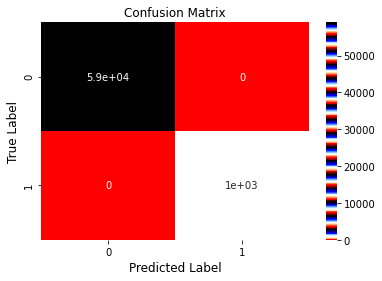

TN = 59000 
FP = 0 
FN = 0 
TP = 1000

The Random Forest Classifier has a misclassification/error rate of 0.0 on the training set


In [28]:
# Calculate and Report the confusion matrix, ROC, AUC, and error rate for the random forest classifier on train data.
# This cell will create the model and report the confusion matrix + error rate

# We could specify any criteria -- like max_depth -- but dont have to
# verbose will make our model run a little slower, but at least we can track its progress
rfc_model = RFC(random_state=1, verbose=1)

rfc_model.fit(aps_trainX_df, aps_trainY_df)

prediction = rfc_model.predict(aps_trainX_df)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(aps_trainY_df, prediction)
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the TP portion of our confusion matrix is the same color as the 0s because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = (fp+fn)/(tn+fp+fn+tp)
rfc_errorD = {}
rfc_errorD["Train Error Rate"] = error_rate
error_rate = round(error_rate, 4)

print()
print("The Random Forest Classifier has a misclassification/error rate of", error_rate, "on the training set")



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


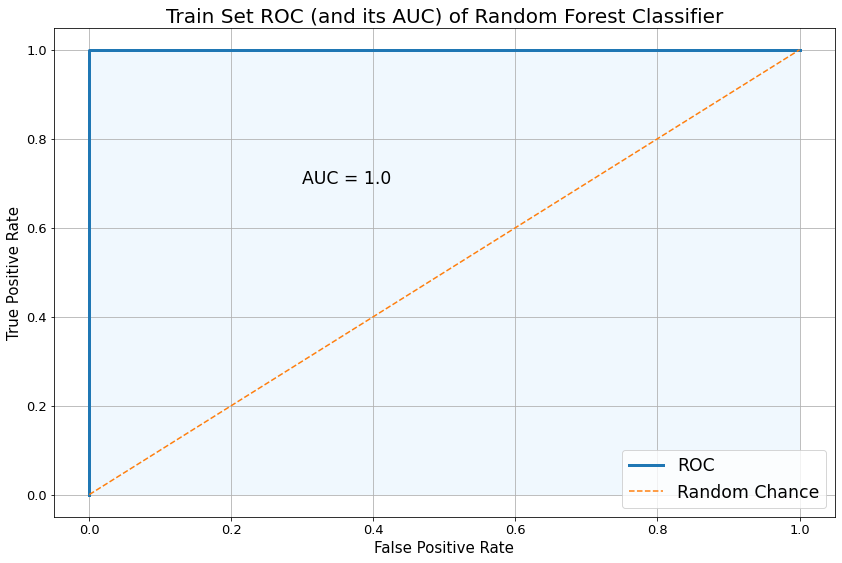

In [29]:
# This cell will report the ROC and AUC of the training set, with the model created in the cell above

prediction_prob = rfc_model.predict_proba(aps_trainX_df)
# .predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_; here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(aps_trainY_df, prediction_prob[:, 1], pos_label="pos")
# The second positional parameter of roc_curve takes y_score: probability estimates of the "positive" class


# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Train Set ROC (and its AUC) of Random Forest Classifier", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
ax.fill_between(fpr, tpr, **kwargs)

plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


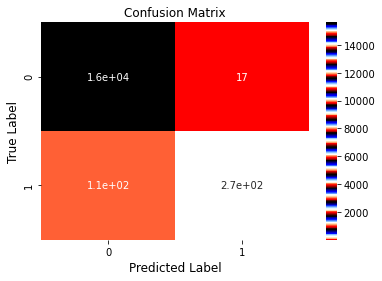

TN = 15608 
FP = 17 
FN = 109 
TP = 266

The Random Forest Classifier has a misclassification/error rate of 0.0079 on the test set


In [30]:
# Calculate and Report the confusion matrix, ROC, AUC, and error rate for the random forest classifier on test set.
# This cell will create the model and report the confusion matrix + error rate

# verbose will make our model run a little slower, but at least we can track its progress
rfc_model = RFC(random_state=1, verbose=1)

rfc_model.fit(aps_trainX_df, aps_trainY_df)

prediction = rfc_model.predict(aps_testX_df)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(aps_testY_df, prediction)
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the FP, FN, and TP portions of our confusion matrix would be colored the same because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = (fp+fn)/(tn+fp+fn+tp)
rfc_errorD["Test Error Rate"] = error_rate
error_rate = round(error_rate, 4)

print()
print("The Random Forest Classifier has a misclassification/error rate of", error_rate, "on the test set")



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


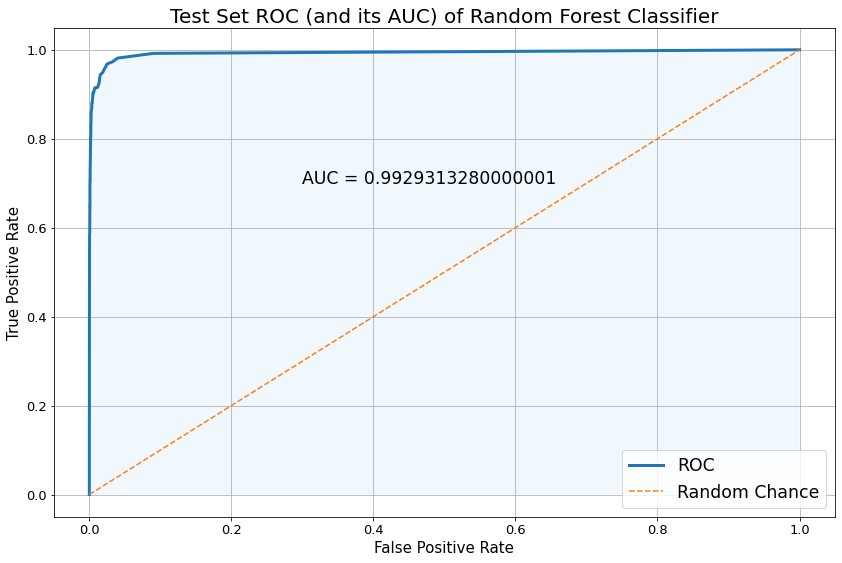

In [31]:
# This cell will report the ROC and AUC of the testing set, with the model created in the cell above

prediction_prob = rfc_model.predict_proba(aps_testX_df)
# .predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_; here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(aps_testY_df, prediction_prob[:, 1], pos_label="pos")
# The second positional parameter of roc_curve takes y_score: probability estimates of the "positive" class


# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Test Set ROC (and its AUC) of Random Forest Classifier", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(fpr, tpr, **kwargs)


plt.show()

In [32]:
# Calculating Out of Bag (OOB) error estimate for random forest

rfc_model = RFC(random_state=1, verbose=1, oob_score=True)

rfc_model.fit(aps_trainX_df, aps_trainY_df)

oob_error = 1-rfc_model.oob_score_
rfc_errorD["OOB Error Rate"] = oob_error
oob_error = round(oob_error, 4)

print("The Random Forest Classifier has an Out-of-Bag error estimate of",  oob_error)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.9s finished


The Random Forest Classifier has an Out-of-Bag error estimate of 0.006


In [33]:
rfc_summary_df = pd.DataFrame.from_dict(rfc_errorD, orient="index", columns=[""])

rfc_summary_df = rfc_summary_df.style.set_caption("Imbalanced Random Forest Classifier").set_table_styles(
    [{"selector":"caption", "props":[('color', 'black'), ('font-size', '15px'), ('font-weight', 'bold'), ('text-align', 'center')]}])

display(rfc_summary_df)


## 2.d

Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


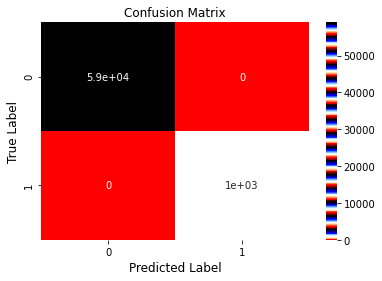

TN = 59000 
FP = 0 
FN = 0 
TP = 1000

The Random Forest Classifier has a misclassification/error rate of 0.0 on the training set


In [34]:
# As the question suggest, we balance our dataset and then redo C

# I am sure there are multiple ways to address imbalanced data (in Random Forest)
# However, with sklearn's randomforestclassifier algorithm, there is a very convenient parameter called class_weight
# Setting "class_weight" to "balanced" will automatically use our Y label to balance the dataset by adjusting weights accordingly
# There are other options like "balanced_subsample", but "balanced" is a viable and straightforward option

# Calculate and Report the confusion matrix, ROC, AUC, and error rate for the random forest classifier on train data.
# This cell will create the model and report the confusion matrix + error rate

# verbose will make our model run a little slower, but at least we can track its progress
rfc_model = RFC(random_state=1, verbose=1, class_weight="balanced")
# This parameter addition is pretty much the main difference between c and d; in hindsight, could've done a function for more efficiency

rfc_model.fit(aps_trainX_df, aps_trainY_df)

prediction = rfc_model.predict(aps_trainX_df)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(aps_trainY_df, prediction)
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the TP portion of our confusion matrix is the same color as the 0s because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = (fp+fn)/(tn+fp+fn+tp)
rfc_errorD = {}
rfc_errorD["Train Error Rate"] = error_rate
error_rate = round(error_rate, 4)

print()
print("The Random Forest Classifier has a misclassification/error rate of", error_rate, "on the training set")



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


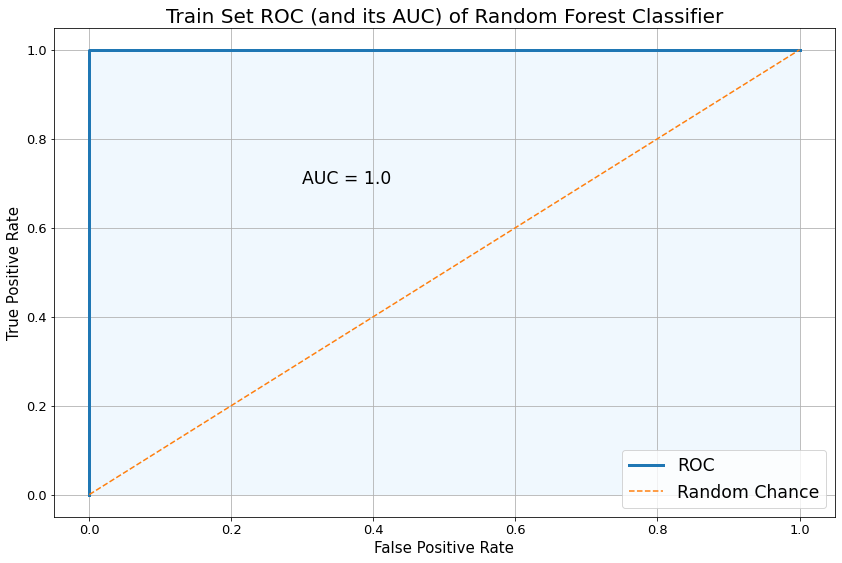

In [35]:
# This cell will report the ROC and AUC of the training set, with the model created in the cell above

prediction_prob = rfc_model.predict_proba(aps_trainX_df)
# .predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_; here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(aps_trainY_df, prediction_prob[:, 1], pos_label="pos")
# The second positional parameter of roc_curve takes y_score: probability estimates of the "positive" class


# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Train Set ROC (and its AUC) of Random Forest Classifier", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
ax.fill_between(fpr, tpr, **kwargs)

plt.show()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


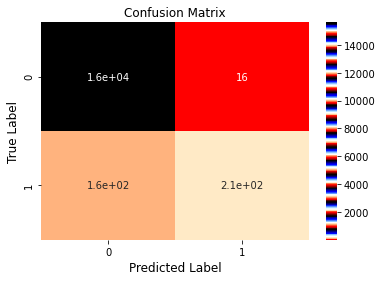

TN = 15609 
FP = 16 
FN = 161 
TP = 214

The Random Forest Classifier has a misclassification/error rate of 0.0111 on the test set


In [36]:
# Calculate and Report the confusion matrix, ROC, AUC, and error rate for the random forest classifier on test set.
# This cell will create the model and report the confusion matrix + error rate

# verbose will make our model run a little slower, but at least we can track its progress
rfc_model = RFC(random_state=1, verbose=1, class_weight="balanced")

rfc_model.fit(aps_trainX_df, aps_trainY_df)

prediction = rfc_model.predict(aps_testX_df)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(aps_testY_df, prediction)
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the FP, FN, and TP portions of our confusion matrix would be colored the same because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = (fp+fn)/(tn+fp+fn+tp)
rfc_errorD["Test Error Rate"] = error_rate
error_rate = round(error_rate, 4)

print()
print("The Random Forest Classifier has a misclassification/error rate of", error_rate, "on the test set")



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


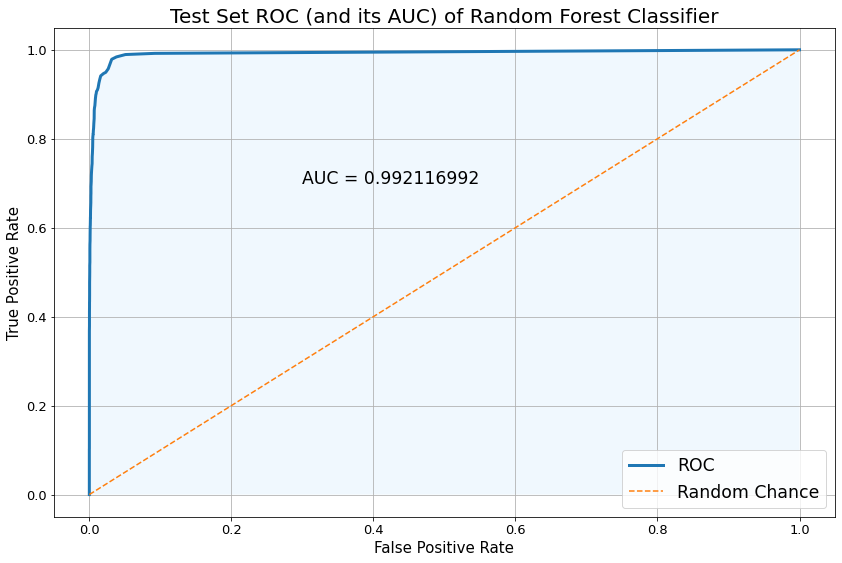

In [37]:
# This cell will report the ROC and AUC of the testing set, with the model created in the cell above

prediction_prob = rfc_model.predict_proba(aps_testX_df)
# .predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_; here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(aps_testY_df, prediction_prob[:, 1], pos_label="pos")
# The second positional parameter of roc_curve takes y_score: probability estimates of the "positive" class


# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Test Set ROC (and its AUC) of Random Forest Classifier", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(fpr, tpr, **kwargs)


plt.show()


In [38]:
# Calculating Out of Bag (OOB) error estimate for random forest 

rfc_model = RFC(random_state=1, verbose=1, oob_score=True, class_weight="balanced")

rfc_model.fit(aps_trainX_df, aps_trainY_df)

oob_error = 1-rfc_model.oob_score_

rfc_errorD["OOB Error Rate"] = oob_error
oob_error = round(oob_error, 4)


print("The Random Forest Classifier has an Out-of-Bag error estimate of",  oob_error)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.3s finished


The Random Forest Classifier has an Out-of-Bag error estimate of 0.0078


In [39]:
rfc_summary_df = pd.DataFrame.from_dict(rfc_errorD, orient="index", columns=[""])

rfc_summary_df = rfc_summary_df.style.set_caption("Balanced Random Forest Classifier").set_table_styles(
    [{"selector":"caption", "props":[('color', 'black'), ('font-size', '15px'), ('font-weight', 'bold'), ('text-align', 'center')]}])

display(rfc_summary_df)


## 2.e
Model Trees

In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has Σj βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

One of the methods that can be used at each node is Logistic Regression. One can use scikit learn to call Weka to train Logistic Model Trees for classification. Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.


>I confirmed to with TA Pratik that the question is asking for the following: <br>
>We need to do a cross-validation of the training set and find the CV's error score. This is what was meant by use "one of ... cross validation methods to estimate the error of your trained model". So, then we report the Confusion Matrix, ROC, and AUC. <br>
>For the test error, we need to retrain the model on the full training set and calculate the test misclassification rate based on the test set's class predictions. Then we report the Confusion Matrix, ROC, and AUC.

>In other words, the model for test error rate calculation shouldn't be training using cross validation, and we don't need to provide the regular training error rate -- just the CV error score and test error.

In [40]:

jvm.start()
# TA said we can ignore the dubug/warning functions is code executes


DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [41]:
# I wasn't sure how to redo imputation in weka, so I create a csv file of the current imputed train/test sets, that the weka will load
# If there was a way to impute with weka, I am still actually not sure which method is more efficient

# Before we create a csv file out of train/test dataframes, we have to process our binary "class" labels to make it weka compatible
# We set the "neg" label to False and the "pos" label to True

aps_trainY_df_weka = aps_trainY_df.copy()
# display(aps_trainY_df_weka.value_counts())
aps_testY_df_weka = aps_testY_df.copy()
# display(aps_testY_df_weka.value_counts())

# changing/transforming column "class" values by row
for set_df in (aps_trainY_df_weka, aps_testY_df_weka):
    for i, val in enumerate(set_df):
        if set_df.iloc[i] == "pos":
            set_df.iloc[i] = True
        elif set_df.iloc[i] == "neg":
            set_df.iloc[i] = False 
# display(aps_trainY_df_weka.value_counts())
# display(aps_testY_df_weka.value_counts())

# Now, we (re)create the total train/test sets which will be converted to csv files
# We use the axis=1 parameter to indicate that it is the columns of the DFs that are being joined together.
aps_train_df_imputed = pd.concat([aps_trainX_df, aps_trainY_df_weka], axis=1)
aps_test_df_imputed = pd.concat([aps_testX_df, aps_testY_df_weka], axis=1)

weka_aps_train_file = "../data/aps_failure_train_set_weka.csv"
weka_aps_test_file = "../data/aps_failure_test_set_weka.csv"

# creating csv file (from pandas df)
aps_train_df_imputed.to_csv(weka_aps_train_file, index=False)
aps_test_df_imputed.to_csv(weka_aps_test_file, index=False)


In [42]:

aps_train_weka = converters.load_any_file(weka_aps_train_file)
aps_test_weka = converters.load_any_file(weka_aps_test_file)

aps_train_weka.class_is_last()
aps_test_weka.class_is_last()

# deleting the cleaned_files from your directory
# ie reseting the data folder to it's default format
# comment out, if you want to keep the imputed files
os.remove(weka_aps_train_file)
os.remove(weka_aps_test_file)


### Calculate and Report the confusion matrix, ROC, AUC, and CV error score for the LMT on a 5-fold validation of the training set.

In [43]:
# https://weka.sourceforge.io/doc.dev/weka/classifiers/Evaluation.html
# keep in mind this cell takes a long time to run; 
# not sure how to track it; TAs I asked also didn't know

# Calculate and Report the confusion matrix, ROC, AUC, and error rate for the LMT on training set.

# creating a Logistic Model Trees (LMT) model for 5-fold cross-validation
lmt_model = Classifier(classname='weka.classifiers.trees.LMT')

evl = Evaluation(aps_train_weka)
# ordered parameters of the crossvalidate_model() are classifier, data, numfolds, and random (which as I understood is equivalent to sklearn's random_state but using weka's Random function)
# couldn't confirm what their specific names in python are
evl.crossvalidate_model(lmt_model, aps_train_weka, 5, Random(1))

# This will take a long time to run


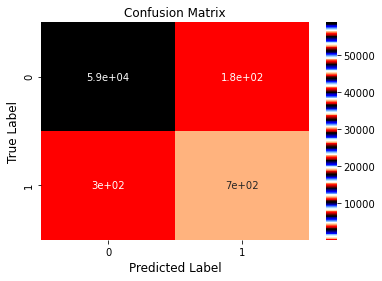

TN = 58818.0 
FP = 182.0 
FN = 303.0 
TP = 697.0

The Logistic Model Trees (LMT) has a 5-fold cross validation misclassification/error score of 0.0081 (on the training set)


In [44]:

# https://fracpete.github.io/python-weka-wrapper/weka.html#weka.classifiers.Evaluation
matrix = evl.confusion_matrix

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the TP portion of our confusion matrix is the same color as the 0s because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = round((1-evl.percent_correct/100), 4)

print()
print("The Logistic Model Trees (LMT) has a 5-fold cross validation misclassification/error score of", error_rate, "(on the training set)")


# For more info on the CV misclassification measurements, uncomment lines below
# print(evl.percent_correct)
# print(evl.summary())
# print(evl.class_details())




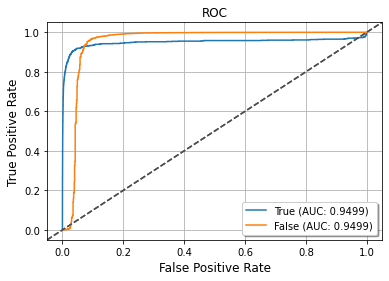

In [45]:
# https://github.com/fracpete/python-weka-wrapper/blob/master/python/weka/plot/classifiers.py
# In the next cell, I used the source code for the plot_roc() fucntion from this link, to tweak the visualization by understanding how weka applies matplotlib 

# The link above has info on plot_roc and it's parameters

# plot ROC curve and get AUC 
plcls.plot_roc(evl, class_index=[1, 0])
# plcls.plot_roc(evl, class_index=[1])# index one is the "pos" class 

# This is weka's built in ROC plotted; 
# However, it didn't seem to have a way to adjust it's visualization through its parameters
# So, below I used the source code of the function to get a better representation -- visible below
# I included both diagrams for reference



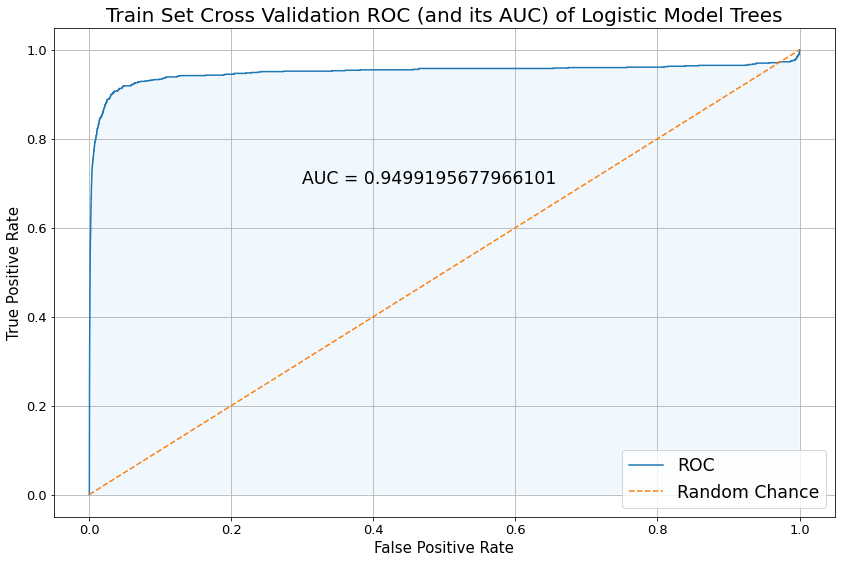

In [46]:
# https://github.com/fracpete/python-weka-wrapper/blob/master/python/weka/plot/classifiers.py
# I used the source code for the plot_roc() fucntion from this link, to tweak the visualization by understanding how weka applies matplotlib 


# since ROC/AUC is the trade-off between the tPr and fPr, we need to identify the "pos" class (which is True here)
# As a general rule of thumb, ROC/AUC of the positive class is used as the standard metric
data = plcls.generate_thresholdcurve_data(evl, 1)
auc_val = plcls.get_auc(data)
fpr, tpr = plcls.get_thresholdcurve_data(data, "False Positive Rate", "True Positive Rate")

fig, ax = plt.subplots(figsize=(14, 9))
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])

ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
# plt.draw()

ax.legend(loc="lower right", fontsize="xx-large")
ax.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
# ax.set_xlabel("False Positive Rate")
# ax.set_ylabel("True Positive Rate")
plt.title("Train Set Cross Validation ROC (and its AUC) of Logistic Model Trees", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(fpr, tpr, **kwargs)

plt.show()


In [47]:
# creating and adding model metrics from CV to a dictionary
# Will be used in 2f to "Compare the uncompensated case with SMOTE."

lmt_summary = {}

In [48]:

lmt_summary["CV Error Score"] = error_rate
lmt_summary["CV AUC"] = auc_val

### Calculate and Report the confusion matrix, ROC, AUC, and error rate for the LMT on the testing set.


We do not want to use the cross-validation train model to calculate the test error. There is no clear way to determine/extract what model (i.e. data and hyperparameters) a classifier that is based on evl.crossvalidate_model() will end up using. Since we do not have access to that information, it wouldn't be right to use that model (even if hypothetically it had a better performance). That is why, we need to retrain our LMT classifier on the whole training set.

In [49]:
# https://fracpete.github.io/python-weka-wrapper3/api.html

# As mentioned at the start of the problem, we need to retrain the model on the regular training set, to them calculate the test error rate

# creating a Logistic Model Trees (LMT) model
lmt_model = Classifier(classname='weka.classifiers.trees.LMT')

# training the model on the full training set
lmt_model.build_classifier(aps_train_weka)

# keep in mind this cell takes a long time to run (i.e. train the classifier); 


In [50]:
# https://fracpete.github.io/python-weka-wrapper3/api.html

predictionL = []
prediction_probL = []

# We loop through every row (i.e. observation) in the test set and make a prediction about it's class
# since we designated the "class" column as our class, classify_instance() won't be used in the prediction process ???
# tqdm will provide a progress bar for the prediction loop
for inst in tqdm(aps_test_weka):
    # this is like sklearn's ".predict()" function
    prediction = lmt_model.classify_instance(inst)
    predictionL.append(prediction)
    # as I understood this is like sklearn's ".predict_proba()" function
    prediction_prob = lmt_model.distribution_for_instance(inst)
    prediction_probL.append(prediction_prob)
    # used for ROC/AUC


100%|██████████| 16000/16000 [00:01<00:00, 8357.06it/s]


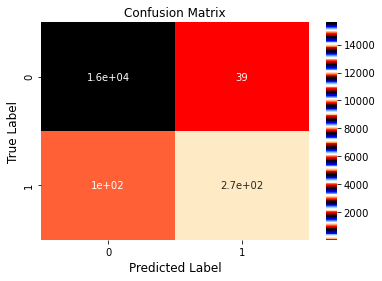

TN = 15586 
FP = 39 
FN = 102 
TP = 273

The Logistic Model Trees (LMT) has a test misclassification/error rate of 0.0088


In [51]:
# This cell will report the confusion matrix and error rate of the testing set, with the model created in the cells above

# convert the predictionL into an array to compare to the real Y classes (which we have as a series)
# Also, weka binary classification prediction is given as a 1/0; so if we are comparing it with our original class label values, we should convert that too

# making a copy to not have to rerun the time consuming cell above, if needed to retest something
predL = predictionL.copy()

for i, pred in enumerate(predL):
    if pred == 0.0:
        predL[i] = "neg"
    elif pred == 1.0:
        predL[i] = "pos"

prediction = np.array(predL)
prediction_prob = np.array(prediction_probL)


# now we can essentially repeat the steps from 2.c to test our classifier's error rate and ROC/AUC

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(aps_testY_df, prediction)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the TP portion of our confusion matrix is the same color as the 0s because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = round((fp+fn)/(tn+fp+fn+tp), 4)

print()
print("The Logistic Model Trees (LMT) has a test misclassification/error rate of", error_rate)


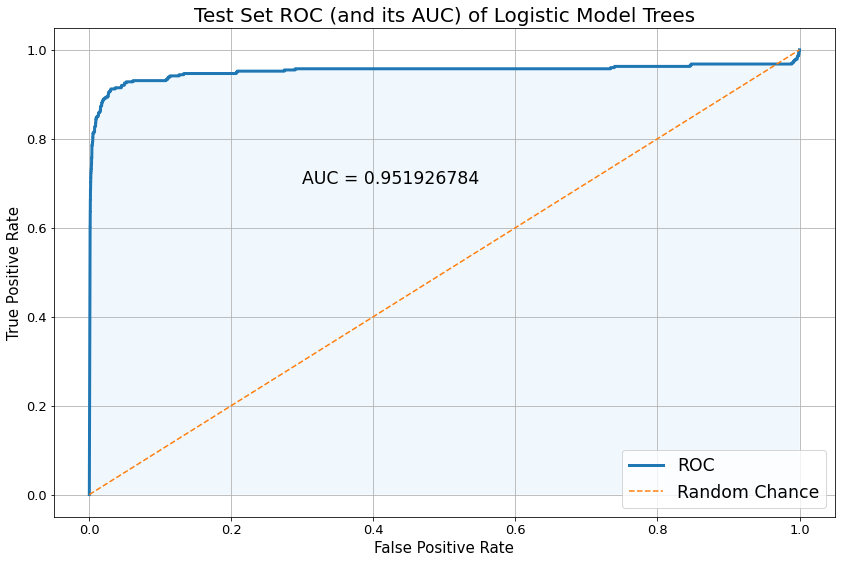

In [52]:
# This cell will report the ROC and AUC of the training set, with the model created in the cells above

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(aps_testY_df, prediction_prob[:, 1], pos_label="pos")
# The second positional parameter of roc_curve takes y_score: probability estimates of the "positive" class


# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Test Set ROC (and its AUC) of Logistic Model Trees", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(fpr, tpr, **kwargs)

plt.show()

jvm.stop()


In [53]:

test_matrix = matrix.copy()
test_tn = tn.copy()
test_fp = fp.copy()
test_fn = fn.copy()
test_tp = tp.copy()
test_error_rate = error_rate.copy()

test_auc_val = auc_val.copy()
test_fpr = fpr.copy()
test_tpr = tpr.copy()


## 2.f

Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

In [54]:
# jvm.stop()

In [55]:
jvm.start(packages=True)


DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Applications/anaconda3/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Applications/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


### Calculate and Report the confusion matrix, ROC, AUC, and CV error score for the LMT on a 5-fold validation of the training set (after 1:5 balancing with SMOTE).

In [57]:
# https://weka.sourceforge.io/doc.dev/weka/classifiers/Evaluation.html
# https://stackoverflow.com/questions/55013347/cross-validation-and-smote-in-weka
# https://fracpete.github.io/python-weka-wrapper3/examples.html
# Specifically, the "Cross-validate filtered classifier and print evaluation and display ROC" part

# The code for 2.f is incredibly similar to that of 2.e
# The main (maybe even only) different is at the start regarding how we create and cross validate our LMT classifier
# before, we just created a regular classifier and cross validated it, with the imbalanced dataset
# Here, we use the Filter and FilteredClassifier functions to apply SMOTE during the cross-validation process


# https://weka.sourceforge.io/doc.stable/weka/filters/supervised/instance/SMOTE.html
SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-P", "1080"])
# -P <percentage> Specifies percentage of SMOTE instances to create. 
# With a -P of 1080%, we will end up with 11,800 minority (i.e. "pos" classes)
# After applying SMOTE, this gives us a minority:majority ratio of 1:5; which TA Pratik confirmed is fine
# SMOTE cross validation is already very long, and would be even longer with 1:1

# creating a Logistic Model Trees (LMT) model for 5-fold cross-validation
lmt_model = Classifier(classname='weka.classifiers.trees.LMT')
fc = FilteredClassifier()
# We set SMOTE as the filter (to oversample the minority class)
fc.filter = SMOTE
fc.classifier = lmt_model


evl = Evaluation(aps_train_weka)
# ordered parameters of the crossvalidate_model() are classifier, data, numfolds, and random (which as I understood is equivalent to sklearn's random_state but using weka's Random function)
# our classifier will be "fc", which is the FilteredClassifier of LMT with SMOTE
evl.crossvalidate_model(fc, aps_train_weka, 5, Random(1))

# This will take a VERY VERY long time to run
# not sure how to track it


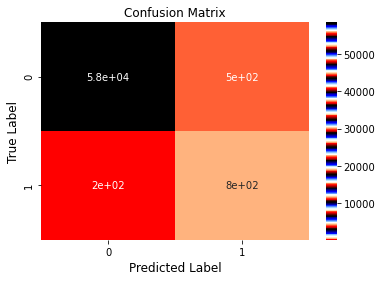

TN = 58498.0 
FP = 502.0 
FN = 201.0 
TP = 799.0

The Logistic Model Trees (LMT) -- based on a 1:5 SMOTE-balanced training set with 5-fold cross validation -- has a CV misclassification/error score of:
0.0117


In [58]:

# https://fracpete.github.io/python-weka-wrapper/weka.html#weka.classifiers.Evaluation
matrix = evl.confusion_matrix

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = round((1-evl.percent_correct/100), 4)

print()
print("The Logistic Model Trees (LMT) -- based on a 1:5 SMOTE-balanced training set with 5-fold cross validation -- has a CV misclassification/error score of:\n" + str(error_rate))


# For more info on the CV misclassification measurements, uncomment lines below
# print(evl.percent_correct)
# print(evl.summary())
# print(evl.class_details())


Since we are doing CV the right way, where SMOTE is applied during the cross-validation process, the CV's internal accuracy measures will be testing on only the true instance (while the synthetical ones will be applied during the training process in the folds). So, keep in mind that even though we did SMOTE, the total N in the confusion matrix is still going to be 60,000.

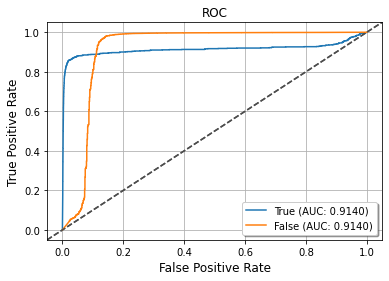

In [59]:
# https://github.com/fracpete/python-weka-wrapper/blob/master/python/weka/plot/classifiers.py
# In the next cell, I used the source code for the plot_roc() fucntion from this link, to tweak the visualization by understanding how weka applies matplotlib 

# The link above has info on plot_roc and it's parameters

# plot ROC curve and get AUC 
plcls.plot_roc(evl, class_index=[1, 0])
# plcls.plot_roc(evl, class_index=[1])
# index one is the "pos" class 

# This is weka's built in ROC plotted; 
# However, it didn't seem to have a way to adjust it's visualization through its parameters
# So, below I used the source code of the function to get a better representation -- visible below
# I included both diagrams for reference


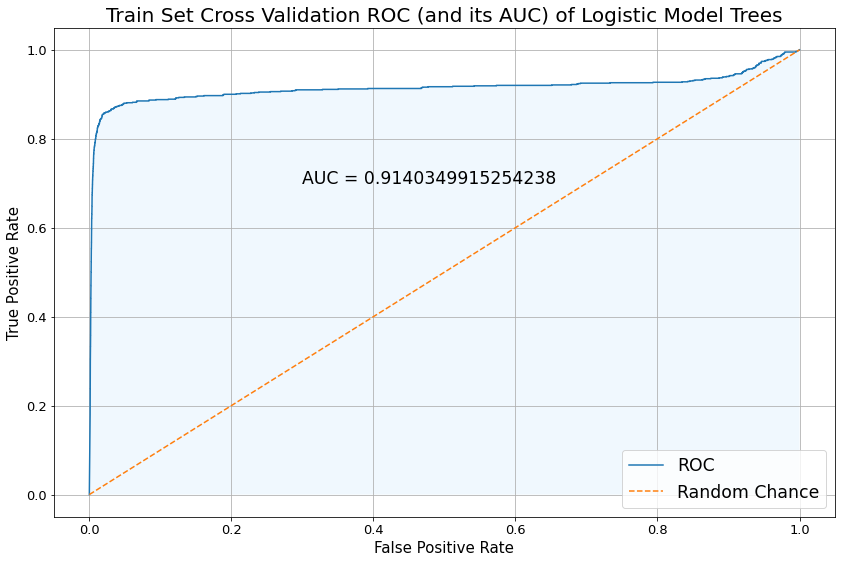

In [60]:
# https://github.com/fracpete/python-weka-wrapper/blob/master/python/weka/plot/classifiers.py
# I used the source code for the plot_roc() fucntion from this link, to tweak the visualization by understanding how weka applies matplotlib 

# since ROC/AUC is the trade-off between the tPr and fPr, we need to identify the "pos" class (which is True here)
# As a general rule of thumb, ROC/AUC of the positive class is used as the standard metric
data = plcls.generate_thresholdcurve_data(evl, 1)
auc_val = plcls.get_auc(data)
fpr, tpr = plcls.get_thresholdcurve_data(data, "False Positive Rate", "True Positive Rate")

fig, ax = plt.subplots(figsize=(14, 9))
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])

ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
# plt.draw()

ax.legend(loc="lower right", fontsize="xx-large")
ax.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
# ax.set_xlabel("False Positive Rate")
# ax.set_ylabel("True Positive Rate")
plt.title("Train Set Cross Validation ROC (and its AUC) of Logistic Model Trees", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(fpr, tpr, **kwargs)

plt.show()


In [61]:
# jvm.stop()

# adding model metrics from CV to a dictionary
# Will be used to "Compare the uncompensated case with SMOTE."

lmt_summary["CV+SMOTE Error Score"] = error_rate
lmt_summary["CV+SMOTE AUC"] = auc_val

#### Test Error (on model trained on full training set without SMOTE)

As earlier discussed, we know to retrain the model when calculating test error. However, I recieved some contradictory information from some of the TAs regarding that we shouldn't use SMOTE without applying cross-validation. Since we don't use CV for test error, this would essentially mean our test error would be the same as that in 2e. Just in case, I included said regular test error here. However, in the next section, I indeed apply SMOTE on the training set (without CV), and get the test error.

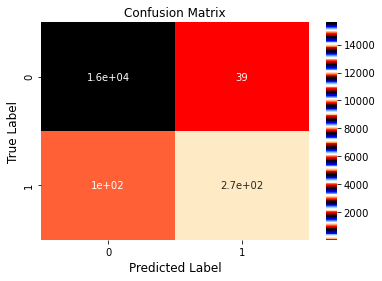

TN = 15586 
FP = 39 
FN = 102 
TP = 273

The Logistic Model Trees (LMT) has a test misclassification/error rate of 0.0088


In [63]:
# The above reasoning was extensively discussed with TA Pratik (and Nandi)

# As you may have noticed, I distinctly initialized the relevant varaibles for the test error (from retraining the model and making test prediction in 2e) 
# As a result, we can avoid an unnecessary and lengthy runtime to retrain the model (the data for which we had previously created already)

# This cell will report the confusion matrix and error rate of the testing set, with the model training on the full training set (created 2e)


# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(test_matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the TP portion of our confusion matrix is the same color as the 0s because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("TN =", test_tn, "\nFP =", test_fp, "\nFN =", test_fn, "\nTP =", test_tp)

print("\nThe Logistic Model Trees (LMT) has a test misclassification/error rate of", test_error_rate)


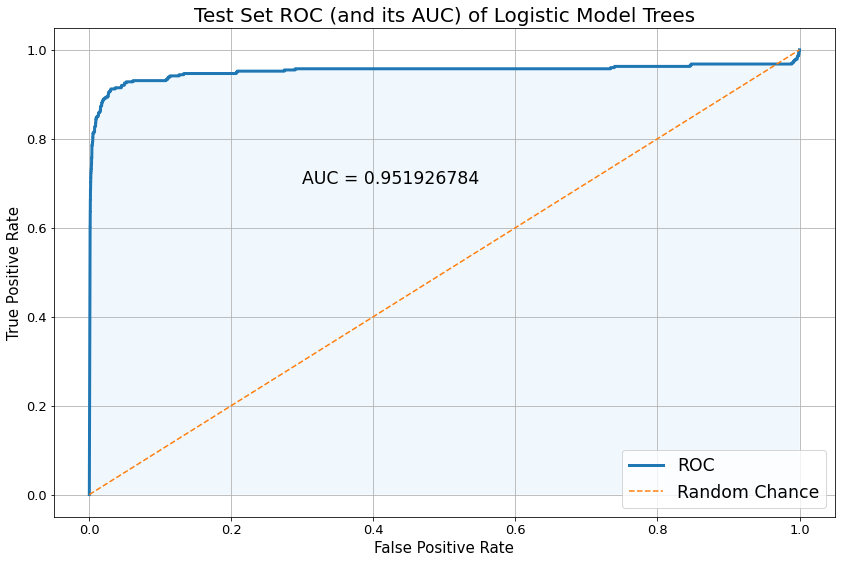

In [64]:
# This cell will report the ROC and AUC of the test set

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(test_fpr, test_tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %test_auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Test Set ROC (and its AUC) of Logistic Model Trees", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(test_fpr, test_tpr, **kwargs)

plt.show()


In [65]:
lmt_summary["Test Error Rate"] = test_error_rate
lmt_summary["Test AUC"] = test_auc_val

### Calculate and Report the confusion matrix, ROC, AUC, and error rate for the LMT on the testing set.


In [66]:
# We continue essentially replicating the steps from 2e
# We need to retrain our model on the full training set and calculate the test error -- per Pratik and Nandi's explanation
# However, like in the parts above, for (f) we need to apply SMOTE on the imbalanced training set first


In [67]:

# from weka.filters import Filter
# from weka.classifiers import FilteredClassifier

# SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-P", "1080"])

# Using this SMOTE percentage will only result a 1:20 SMOTE ratio -- unlike the 1:5 used with CV
# As we agreed with TA Gupta, Having 1:5 when classifying the instances would ALWAYS kill the kernel -- likely due to too great a burden/overload 
# So, per TA suggestion, to prevent the kernel dying we SMOTE a smaller amount
# Although this doesn't completely balance our dataset, we can still see the affect it will have on accuracy (albeit to a smaller degree)
SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-P", "195"])
# If you want to see yourself what happens, uncomment out this line


In [ ]:
# https://fracpete.github.io/python-weka-wrapper3/api.html

# As mentioned at the start of the problem, we need to retrain the model on the regular training set, to them calculate the test error rate

# creating a Logistic Model Trees (LMT) model 
lmt_model = Classifier(classname='weka.classifiers.trees.LMT')
fc = FilteredClassifier()
# We set SMOTE as the filter (to oversample the minority class)
fc.filter = SMOTE
fc.classifier = lmt_model


# training the model on the full training set (while applying SMOTE with the filter)
fc.build_classifier(aps_train_weka)

# keep in mind this cell takes a long time to run (i.e. train the classifier); 


In [ ]:
# https://fracpete.github.io/python-weka-wrapper3/api.html

predictionL = []
prediction_probL = []

# We loop through every row (i.e. observation) in the test set and make a prediction about it's class
# since we designated the "class" column as our class, classify_instance() won't be used in the prediction process ???
# tqdm will provide a progress bar for the prediction loop
for inst in aps_test_weka:
    # this is like sklearn's ".predict()" function
    prediction = fc.classify_instance(inst)
    predictionL.append(prediction)
    # this is like sklearn's ".predict_proba()" function
    prediction_prob = fc.distribution_for_instance(inst)
    prediction_probL.append(prediction_prob)
    # used for ROC/AUC

# Also, for some reason, I think using tqdm here contibuted to killing the kernel


In [ ]:
# This cell will report the confusion matrix and error rate of the testing set, with the model created in the cells above

# convert the predictionL into an array to compare to the real Y classes (which we have as a series)
# Also, weka binary classification prediction is given as a 1/0; so if we are comparing it with our original class label values, we should convert that too

# making a copy to not have to rerun the time consuming cell above, if needed to retest something
predL = predictionL.copy()

for i, pred in enumerate(predL):
    if pred == 0.0:
        predL[i] = "neg"
    elif pred == 1.0:
        predL[i] = "pos"

prediction = np.array(predL)
prediction_prob = np.array(prediction_probL)


# now we can essentially repeat the steps from 2.c to test our classifier's error rate and ROC/AUC

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(aps_testY_df, prediction)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True, cmap="flag")
# had to pick a cmap with a more sensitive color range
# Otherwise the TP portion of our confusion matrix is the same color as the 0s because the classes are imbalanced -- with most being negatives
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

error_rate = round((fp+fn)/(tn+fp+fn+tp), 4)

print()
print("The Logistic Model Trees (LMT) -- with a 1:20 SMOTE-balanced training set -- has a test misclassification/error rate of", error_rate)


In [ ]:
# This cell will report the ROC and AUC of the training set, with the model created in the cells above

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(aps_testY_df, prediction_prob[:, 1], pos_label="pos")
# The second positional parameter of roc_curve takes y_score: probability estimates of the "positive" class


# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size
fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Test Set ROC (and its AUC) of Logistic Model Trees -- with SMOTE", fontsize=20)

kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC 
ax.fill_between(fpr, tpr, **kwargs)

plt.show()

jvm.stop()


In [ ]:
# creating and adding model metrics from CV to a dictionary
# Will be used in 2f to "Compare the uncompensated case with SMOTE."

lmt_summary["( SMOTE) Test Error Rate"] = error_rate
lmt_summary["(SMOTE) Test AUC"] = auc_val

lmt_summary_df = pd.DataFrame.from_dict(lmt_summary, orient="index", columns=[""])

lmt_summary_df = lmt_summary_df.style.set_caption("Logistic Model Tree Classifier").set_table_styles(
    [{"selector":"caption", "props":[('color', 'black'), ('font-size', '15px'), ('font-weight', 'bold'), ('text-align', 'center')]}])

display(lmt_summary_df)


In [ ]:
# jvm.start(packages=True)

In [ ]:
# jvm.stop()

## 3. ISLR 6.8.3/6.6.3
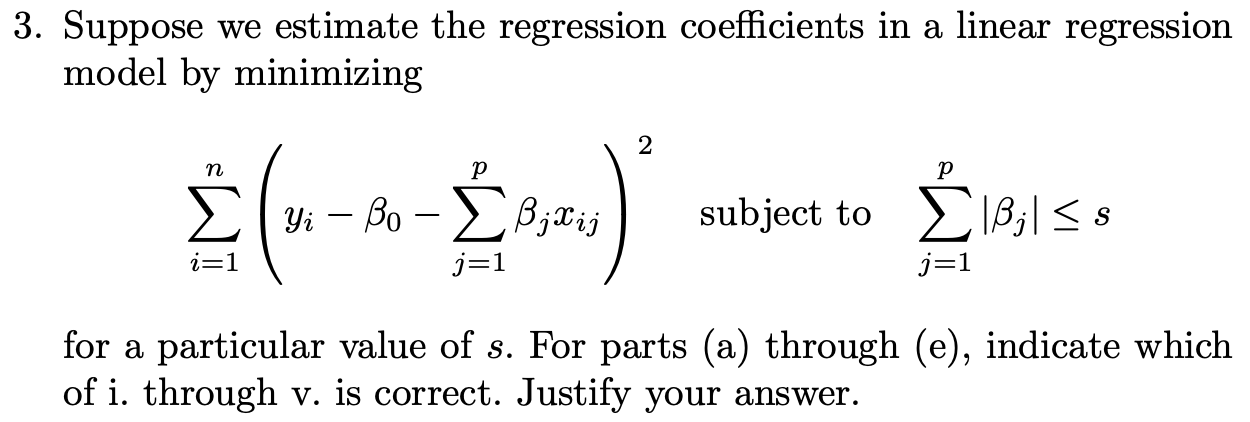
i. Increase initially, and then eventually start decreasing in an
inverted U shape. <br>
ii. Decrease initially, and then eventually start increasing in a U shape. <br>
iii. Steadily increase. <br>
iv. Steadily decrease. <br>
v. Remain constant. <br>

(a) As we increase s from 0, the training RSS will:
>It will "Steadily decrease" (iv).<br>As s increases from 0, the constraint on β will decrease. So, the RSS will also decrease until it converges with the OLS answer.

(b) Repeat (a) for test RSS. 
>It will "Decrease initially, and then eventually start increasing in a U shape" (ii).<br>As s=0, the βs also equal 0; such a model has a high RSS. So, when we increase s, the βs start increasing as they fit the model better -- which decreases the RSS. However, as s (predictors) continues to increase and the model becomes increasingly flexible, it eventually results in overfitting on the training data. This causes the test RSS to increase again -- leading to a U shape.

(c) Repeat (a) for variance.
>It will "Steadily increase" (iii).<br>When s=0, our model predictions are practically constant; so, there would be little to no variance in this situation. Therefore, as we increase s from 0, the we get new estimated coefficients (β) and their values increase. Our model becomes increasing more flexible. The β value are dependant on the training data which will increase the variance of the model.

(d) Repeat (a) for (squared) bias.
>It will "Steadily decrease" (iv).<br>As we know from the bias-variance trade-off, when variance goes up, bias goes down (and vice versa). Since we established in (c) that increasing s would increase the variance, we can conclude that bias woul go down. In more detail, as we mentioned, a prediction model with s=0 has constant predictions which results in many wrong (i.e. not close) values to the real data. So it start off with high bias. Therefore, getting more (non-zero) βs improves our fit on the training set -- thus decreasing bias.

(e) Repeat (a) for the irreducible error.
>It will "Remain constant" (v).<br>Irreducble error is called "irreducible" precicely because it is independent from the model. So, it won't change regardless of how the (hyper)parameters are tuned.


## 4. ISLR 6.8.5/6.6.5
It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite dif- ferent coefficient values to correlated variables. We will now explore this property in a very simple setting. <br>
Suppose that n = 2, p = 2, x₁₁ = x₁₂, x₂₁ = x₂₂. Furthermore, suppose that y₁+y₂=0 and x₁₁+x₂₁=0 and x₁₂+x₂₂ = 0, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: βˆ₀ = 0.

(a) Write out the ridge regression optimization problem in this setting.

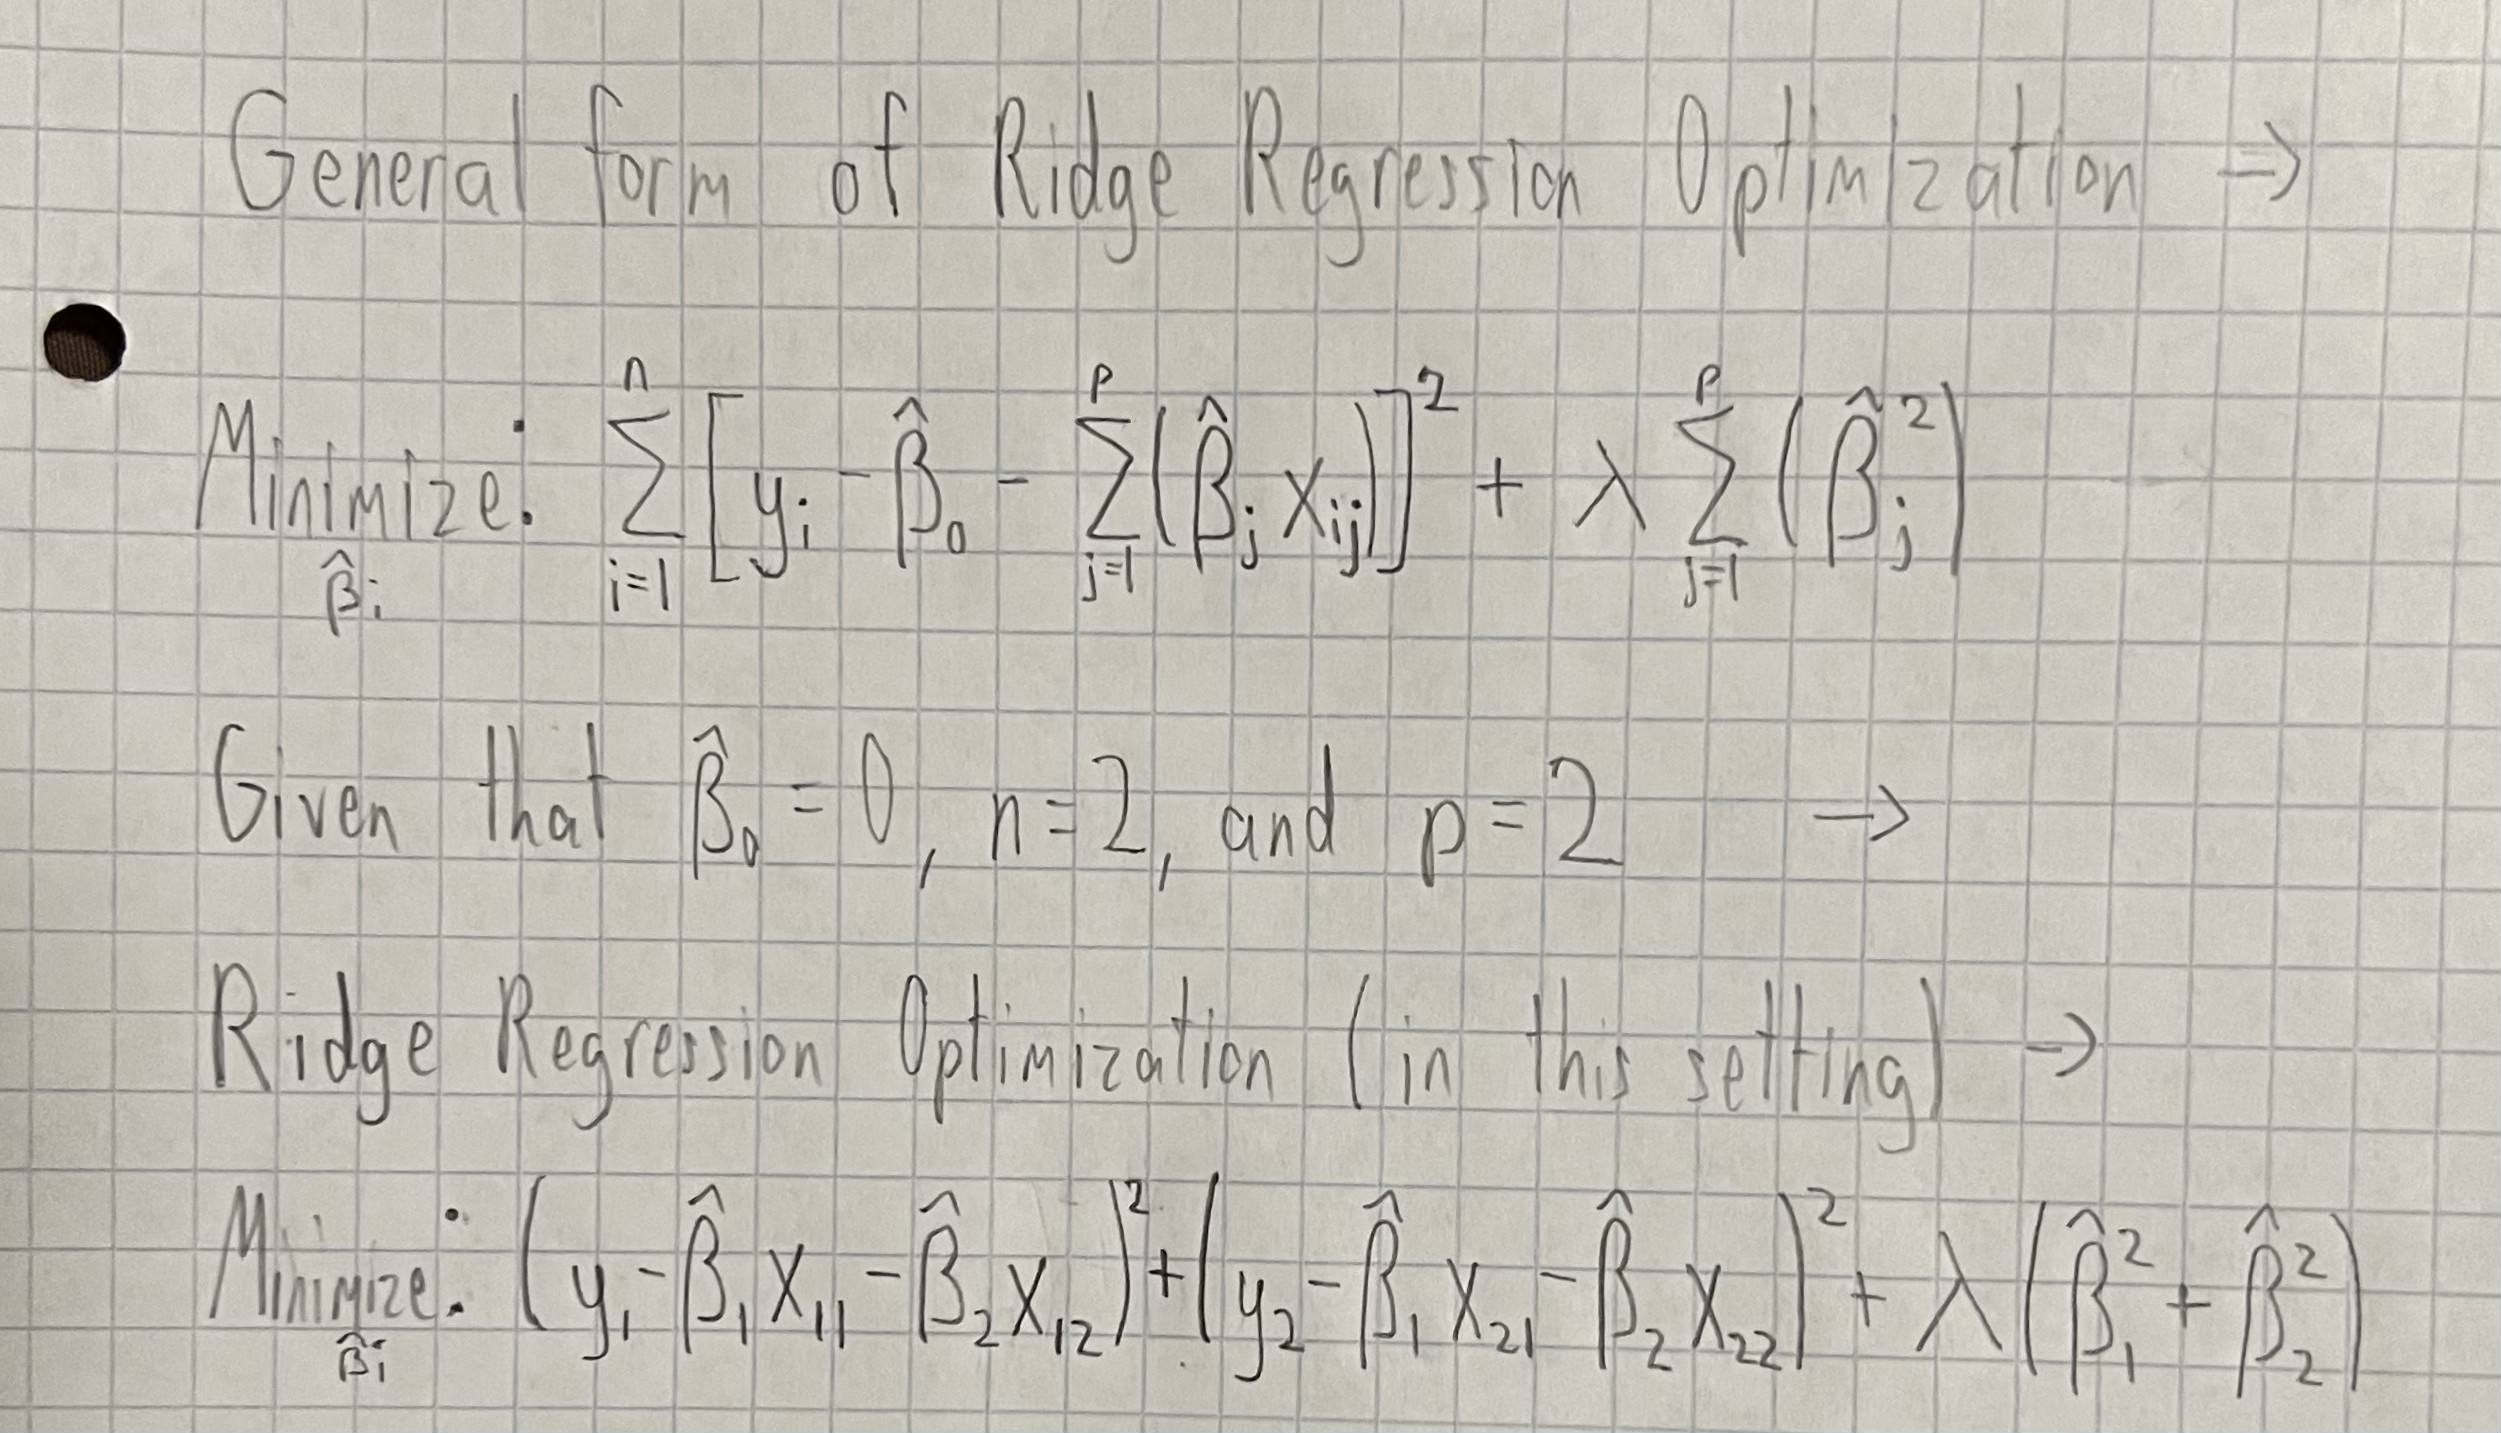

(b) Argue that in this setting, the ridge coefficient estimates satisfy βˆ₁ = βˆ₂.

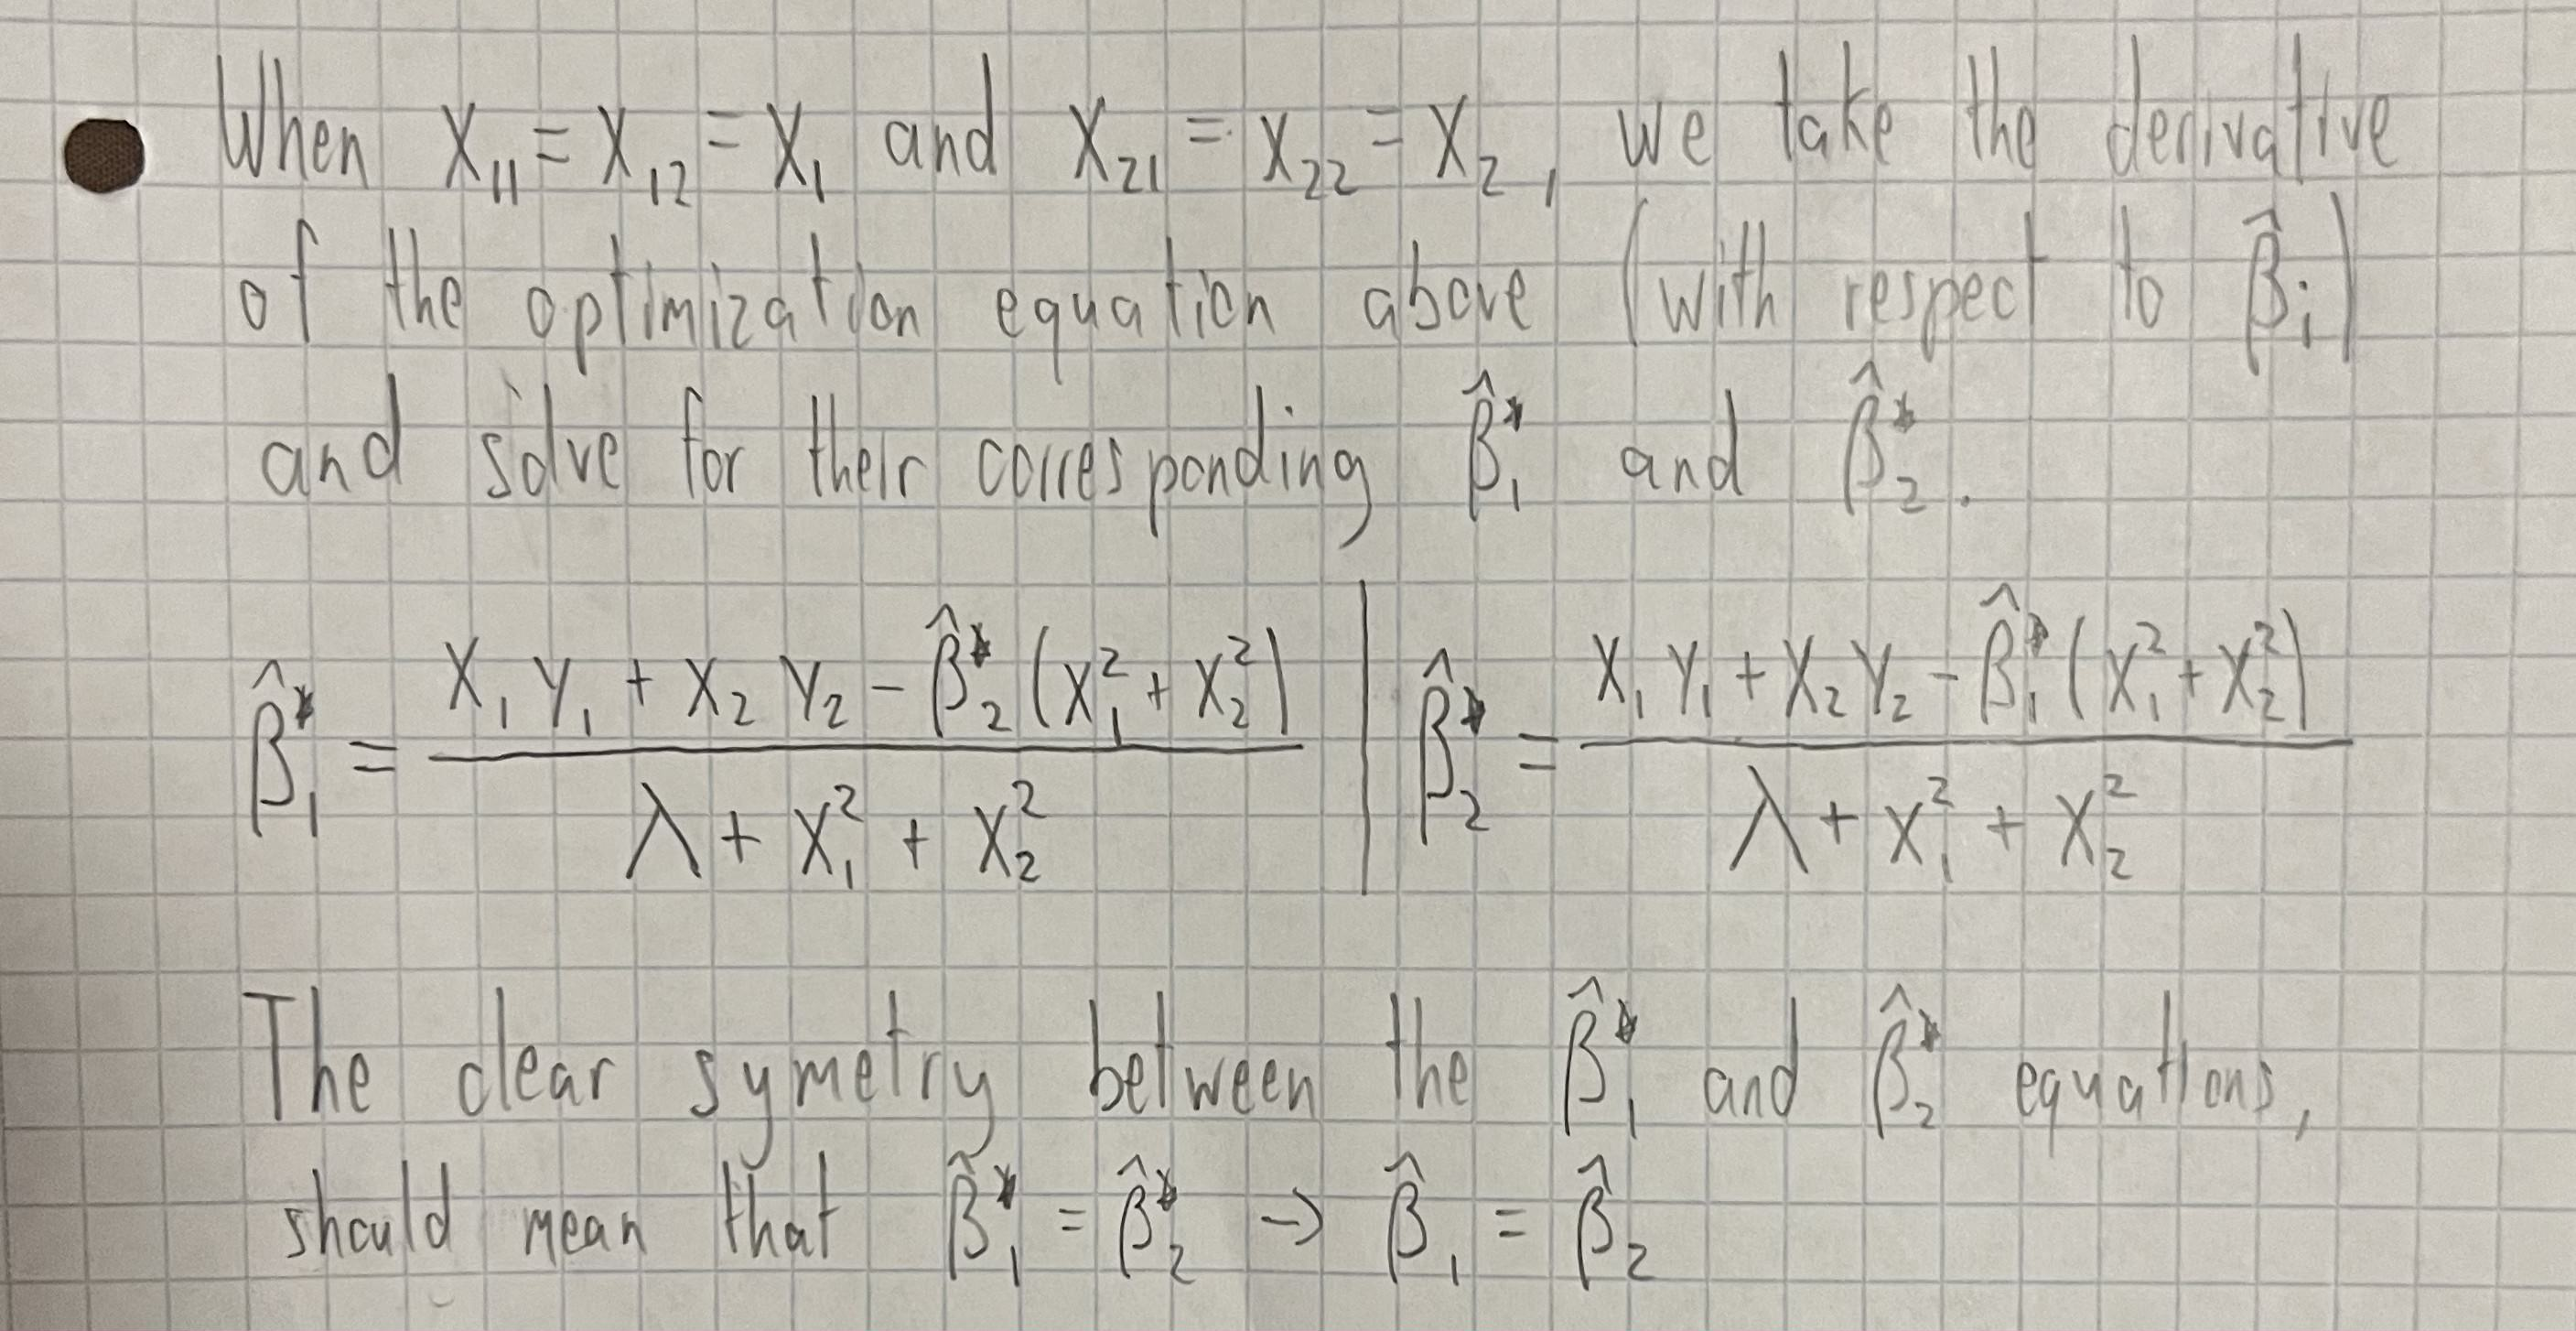

(c) Write out the lasso optimization problem in this setting.

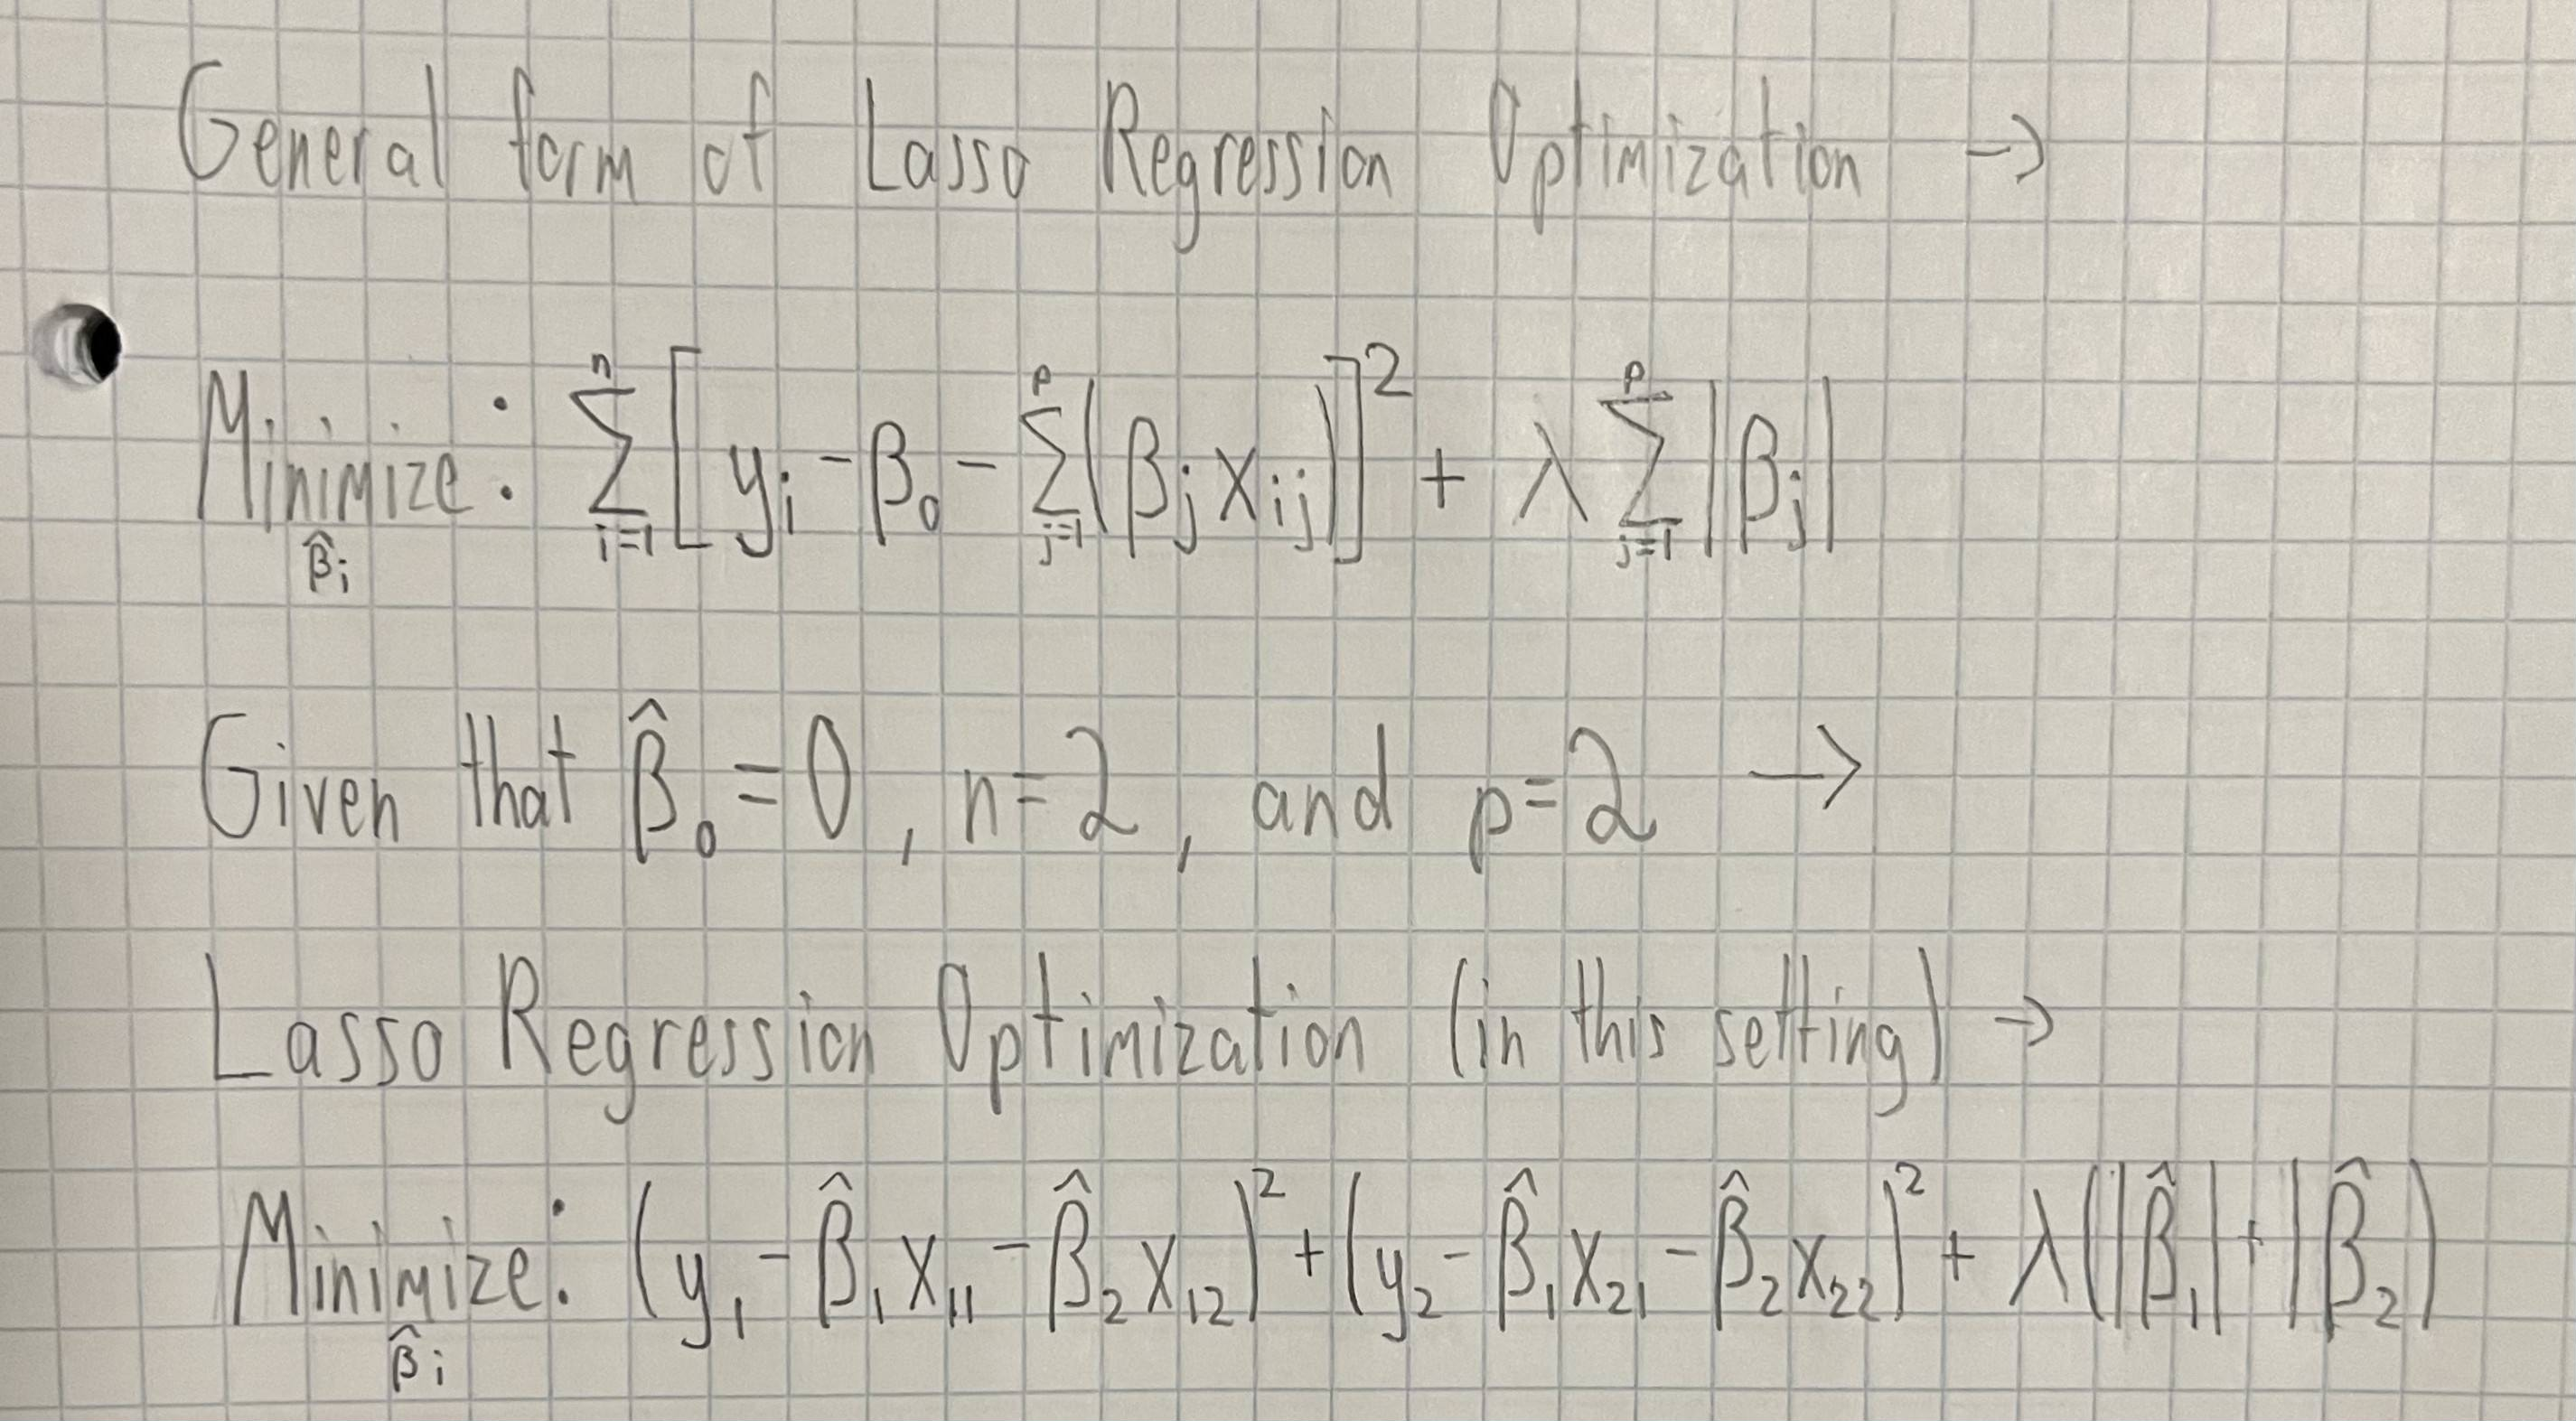

(d) Argue that in this setting, the lasso coefficients βˆ₁ and βˆ₂ are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

>Figure 6.7 (on page 244 of the ISLR book) gives a geometric interpretation of the Lasso Regression's constraint functions. The Lasso constraint regions contour is represented by |β̂₁|+|β̂₂|<s. This creates a diamond shape with an origin of (0,0). 

>Given this and that x₁₁=x₁₂, x₂₁=x₂₂, x₁₁+x₂₁=0, x₁₂+x₂₂=0 and y₁+y₂=0, we can simlpify the Lasso optimization constraint from above -- (y₁−β̂₁x₁₁−β̂₂x₁₂)$^2$+(y₂−β̂₁x₂₁−β̂₂x₂₂)$^2$ -- to get the following.<br>
Minimize: 2*[y₁−(β̂₁+β̂₂)x₁₁]$^2$.

>Based on this simplified optimization equation, the solution for minimization would be at: β̂₁+β̂₂=y₁/x₁₁. Clearly, many different combinations of β̂₁ and β̂₂ can satisfy the equality β̂₁+β̂₂=y₁/x₁₁. In this setting the Lasso coefficients (β̂₁ and β̂₂) are not unique. Also, the line of the (earlier mentioned) Lasso diamond's side is β̂₁+β̂₂=s. Our optimization solution (β̂₁+β̂₂=y₁/x₁₁) runs parallel to it. Solutions of the original Lasso optimization problem are contours of the function [y₁−(β̂₁+β̂₂)x₁₁]$^2$; they touch the Lasso diamond β̂₁+β̂₂=s. Overall, we can conclude that <br>all β̂₁+β̂₂=s (and similarly β̂₁+β̂₂=−s) can be possible solutions to the Lasso optimization problem.

>In other words, these possible solutions can be represented as: <br>
>β̂₁+β̂₂=s; β̂₁≥0; β̂₂≥0 <br>and <br>β̂₁+β̂₂=−s; β̂₁≤0; β̂₂≤0

## 5. ISLR 8.4.5
Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X): <br>
0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7, and 0.75.

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

>For majority voting (classification), from our 10 estimates we see that there is a greater number of red predictions than green -- i.e. count for [ P(Class is Red|X)>0.5 ] > count for [ P(Class is Red|X)<0.5 ]. So, per majority voting, X is classified RED.

>Average probability of P(Class is Red|X) = 4.5/10 = 0.45. So, per average probability, X is classified GREEN.

## 6. ISLR 9.7.3
Here we explore the maximal margin classifier on a toy data set.

(a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label. <br>
Sketch the observations.

In [ ]:
table = [[3,4,"Red"], [2,2,"Red"], [4,4,"Red"], [1,4,"Red"], [2,1,"Blue"], [4,3,"Blue"], [4,1,"Blue"]]

table_df = pd.DataFrame(table, index=[1,2,3,4,5,6,7], columns=["X₁", "X₂", "Y"])
display(table_df)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
# Link above is related to what we need, but doesn't have explanations
# https://towardsdatascience.com/support-vector-machines-explained-with-python-examples-cb65e8172c85
# The towardsdatascience link uses pretty much the exact same method, so I assume this must the accepted form

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

svc_model = SVC(kernel="linear", C=100)
# training the support vector classifier with our dataset's x and y variables

dataXs = table_df.iloc[:, :-1]
dataY = table_df.iloc[:, -1]
svc_model.fit(dataXs, dataY)


# https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html


In [ ]:

palette = {"Red":"tab:red","Blue":"tab:blue"}

fig, ax = plt.subplots(figsize=(8, 8))
scatterplot = sns.scatterplot(x=table_df["X₁"], y=table_df["X₂"], hue= table_df["Y"], s=100, palette=palette, ax=ax)

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# plt.xlim(xlim[0]-1, xlim[1]+1)
# plt.ylim(ylim[0]-1, ylim[1]+1)

plt.grid(True)
plt.rcParams["axes.labelsize"] = 18

plt.show()


(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).

In [ ]:

# We want to plot the optimal separating hyperplane (ie maximal margin classifier)

fig, ax = plt.subplots(figsize=(8, 8))

# scatter plot of sample points
scatterplot = sns.scatterplot(x=table_df["X₁"], y=table_df["X₂"], hue= table_df["Y"], s=100, palette=palette, ax=ax)

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# plt.xlim(xlim[0]-1, xlim[1]+1)
# plt.ylim(ylim[0]-1, ylim[1]+1)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], len(dataXs))
yy = np.linspace(ylim[0], ylim[1], len(dataY))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc_model.decision_function(xy).reshape(XX.shape)

# optimal seperating hyperplane
line = ax.contour(XX, YY, Z, colors="k", levels=[0], alpha=0.7, linestyles=["-"])

plt.grid(True)
plt.rcParams["axes.labelsize"] = 15

# not sure how else to add label to existing legend; discovered this workaround
x = 1
y = 1
plt.plot(x, y, "-k", label = "Optimal Seperating Hyperplane")
plt.legend(loc="center left", fontsize=9)

plt.show()

# print(clf.intercept_, clf.coef_)


Per the the equation β₀ + β₁X₁ + β₂X₂ = 0,  → <br>
The optimal seperating hyperplane's equation is:
>0.5 - X₁ + X₂ = 0 <br>
>Where the intercept is -0.5 and the slope is 1.

(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if β₀ + β₁X₁ + β₂X₂ > 0, and classify to Blue otherwise.” Provide the values for β₀, β₁, and β₂.

Classify to Red if:
>0.5 - X₁ + X₂ > 0 <br>
>β₀ = 0.5;  β₁ = -1;  β₂ = 1

Otherwise classify to Blue



(d) On your sketch, indicate the margin for the maximal margin hyperplane.

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))

# scatter plot of sample points
scatterplot = sns.scatterplot(x=table_df["X₁"], y=table_df["X₂"], hue= table_df["Y"], s=100, palette=palette, ax=ax)
# ax.scatter(table_df.iloc[:, 0], table_df.iloc[:, 1], 
#            c=sample_df.iloc[:, -1], s=30, 
#            cmap=plt.cm.Paired)

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# plt.xlim(xlim[0]-1, xlim[1]+1)
# plt.ylim(ylim[0]-1, ylim[1]+1)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], len(dataXs))
yy = np.linspace(ylim[0], ylim[1], len(dataY))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc_model.decision_function(xy).reshape(XX.shape)

# optimal seperating hyperplane and its margins
lines = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
margin = ax.plot((3, 3.5), (3, 2.5), linestyle=":", c="m", lw=2)

plt.grid(True)
plt.rcParams["axes.labelsize"] = 15

# not sure how else to add label to existing legend; discovered this workaround
x = 1
y = 1
plt.plot(x, y, "-k", label = "Optimal Seperating Hyperplane")
plt.plot(x, y, ":m", label = "Margin")
plt.plot(x, y, "--k", label = "Margin Boundaries")

plt.legend(loc="center left", fontsize=9)

plt.show()


(e) Indicate the support vectors for the maximal margin classifier.

In [ ]:
# svc_model.support_vectors_ attribute gives the sv classifier's support vectors
support_vectorsL = [tuple(sup_vect) for sup_vect in svc_model.support_vectors_]
new_col = []

for (x1, x2) in zip(table_df.iloc[:, 0], table_df.iloc[:, 1]):
#     print(x1, x2)
    if (x1, x2) in support_vectorsL:
#         print(True)
        new_col.append("Support Vector")
    else:
        new_col.append(" ")

# adding a column that identifies the support vectors
table_df["Type"] = new_col

# I am doing this part, only for the visual benefit of the legend
# There is probably a better way to space out the legend section, but I couldnt find it
table_df = table_df.rename(columns={"Y":" ", "Type":"  "})


In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))

# scatter plot of sample points
scatterplot = sns.scatterplot(x=table_df["X₁"], y=table_df["X₂"], hue= table_df[" "], style=table_df["  "], s=100, palette=palette, ax=ax)
# ax.scatter(table_df.iloc[:, 0], table_df.iloc[:, 1], 
#            c=sample_df.iloc[:, -1], s=30, 
#            cmap=plt.cm.Paired)

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# plt.xlim(xlim[0]-1, xlim[1]+1)
# plt.ylim(ylim[0]-1, ylim[1]+1)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], len(dataXs))
yy = np.linspace(ylim[0], ylim[1], len(dataY))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc_model.decision_function(xy).reshape(XX.shape)

# optimal seperating hyperplane and its margins
lines = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
margin = ax.plot((3, 3.5), (3, 2.5), linestyle=":", c="m", lw=2)

plt.grid(True)
plt.rcParams["axes.labelsize"] = 15

# not sure how else to add label to existing legend; discovered this workaround
x = 1
y = 1
plt.plot(x, y, "-k", label = "Optimal Seperating Hyperplane")
plt.plot(x, y, ":m", label = "Margin")
plt.plot(x, y, "--k", label = "Margin Boundaries")

plt.legend(loc="center left", bbox_to_anchor=(0, 0.6), fontsize=9, columnspacing=55, markerscale=1.5)

plt.show()

print("As visible in the diagram above, the support vectors for the maximal margin classifier are:")
for sv in support_vectorsL:
    print(sv)




(f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

>The 7th obseration is data point (4,1) with class Blue. This observation is not a support vector, but rather is one of the furthest points from the maximal margin hyperplane. We know that the maximal margin hyperplane is only altered by changes in its support vectors. Since no slight movement will make observation 7 enter the margin space (and become a new support vector), it stands that a slight movement of the seventh observation would not affect the maximal margin hyperplane. 

(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))

# scatter plot of sample points
scatterplot = sns.scatterplot(x=table_df["X₁"], y=table_df["X₂"], hue= table_df[" "], style=table_df["  "], s=100, palette=palette, ax=ax)
# ax.scatter(table_df.iloc[:, 0], table_df.iloc[:, 1], 
#            c=sample_df.iloc[:, -1], s=30, 
#            cmap=plt.cm.Paired)

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# plt.xlim(xlim[0]-1, xlim[1]+1)
# plt.ylim(ylim[0]-1, ylim[1]+1)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], len(dataXs))
yy = np.linspace(ylim[0], ylim[1], len(dataY))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc_model.decision_function(xy).reshape(XX.shape)

# optimal seperating hyperplane and its margins
lines = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
margin = ax.plot((3, 3.5), (3, 2.5), linestyle=":", c="m", lw=2)

# hyperplane that is not the optimal separating hyperplane
line2 = ax.contour(XX, YY, Z-0.6, colors="c", levels=[0], alpha=0.7, linestyles=["-"])


plt.grid(True)
plt.rcParams["axes.labelsize"] = 15



# not sure how else to add label to existing legend; discovered this workaround
x = 1
y = 1
plt.plot(x, y, "-k", label = "Optimal Seperating Hyperplane")
plt.plot(x, y, ":m", label = "Margin")
plt.plot(x, y, "--k", label = "Margin Boundaries")
plt.plot(x, y, "-c", label = "(Other) Seperating Hyperplane")

plt.legend(loc="center left", bbox_to_anchor=(0, 0.7), fontsize=9, columnspacing=55, markerscale=1.5)

plt.show()


Per the the equation β₀ + β₁X₁ + β₂X₂ = 0,  → <br>
An example of a hyperplane (that is not the maximal margin classifier) is:
>0.2 - X₁ + X₂ = 0 <br>
>Where the intercept is -0.2 and the slope is 1.


(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

In [ ]:

# adding additional observation to our dataset, that makes the classes non-seperable by a hyperplane
table_df.loc[len(table_df.index)+1] = [2,2.5, "Blue", "Additional (Noisy) Observation"] 

# We want to plot the optimal separating hyperplane (ie maximal margin classifier)

# plot graph
fig, ax = plt.subplots(figsize=(8, 8))

# scatter plot of sample points
scatterplot = sns.scatterplot(x=table_df["X₁"], y=table_df["X₂"], hue= table_df[" "], style=table_df["  "], s=100, palette=palette, ax=ax)
# ax.scatter(table_df.iloc[:, 0], table_df.iloc[:, 1], 
#            c=sample_df.iloc[:, -1], s=30, 
#            cmap=plt.cm.Paired)

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# plt.xlim(xlim[0]-1, xlim[1]+1)
# plt.ylim(ylim[0]-1, ylim[1]+1)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], len(dataXs))
yy = np.linspace(ylim[0], ylim[1], len(dataY))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc_model.decision_function(xy).reshape(XX.shape)

# optimal seperating hyperplane and its margins
lines = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
margin = ax.plot((3, 3.5), (3, 2.5), linestyle=":", c="m", lw=2)

# hyperplane that is not the optimal separating hyperplane
line2 = ax.contour(XX, YY, Z-0.6, colors="c", levels=[0], alpha=0.7, linestyles=["-"])


plt.grid(True)
plt.rcParams["axes.labelsize"] = 15



# not sure how else to add label to existing legend; discovered this workaround
x = 1
y = 1
plt.plot(x, y, "-k", label = "Optimal Seperating Hyperplane")
plt.plot(x, y, ":m", label = "Margin")
plt.plot(x, y, "--k", label = "Margin Boundaries")
plt.plot(x, y, "-c", label = "(Other) Seperating Hyperplane")

plt.legend(loc="center left", bbox_to_anchor=(0, 0.7), fontsize=9, columnspacing=55, markerscale=1.5)

plt.show()
